In [26]:
import notebook
notebook.nbextensions.check_nbextension('usability/codefolding', user=True)
notebook.nbextensions.check_nbextension('usability/codefolding/main.js', user=True)
E = notebook.nbextensions.EnableNBExtensionApp()
E.enable_nbextension('usability/codefolding/main')

In [27]:
%%writefile serre.py

import numpy as np
import matplotlib.pyplot as plt
import nswe
import math
import muscl2


Overwriting serre.py


$\newcommand{\th}{\tilde{h}}$
$\newcommand{\tu}{\tilde{u}}$

$\newcommand{\lh}{\overline{h}}$
$\newcommand{\lu}{\overline{u}}$

$\newcommand{\Atwo}[2]{\left( \begin{array}{c} #1 \\ #2  \end{array} \right)}$

# Numerical resolution of the Serre equations

## The model

The Serre equations are a model to describe higly nonlinear waves propagating in shallow waters. Considering a horizontal bottom, these equations are written as

\begin{equation}
\label{eq:SerreFull}
h_t + (hu)_x = 0 \\
u_t + uu_x + gh_x - \frac{1}{3h}\left(h^3 \left( u_{xt} + uu_{xx} - (u_x)^2  \right) \right)_x = 0
\end{equation}

where $u = u(x,t)$, $h = h(x,t)$ and $g$ are, respectively, the depth-averaged horizontal velocity of the fluid, the water depth and the gravity acceleration.

## Discretization

As done previously for the numerical resolution of the KdV and the BBM equations, the Serre equations will be numerically solved using a splitting method, in which the system of equations will be decomposed in two : the first one will contain the advection terms, and the second one, all the high-order derivative terms.

Therefore, the numerical resolution will consist in solve, in each time step $[t_n, t_{n+1}]$, the following problem :

\begin{equation}
\label{eq:SerreSplit1}
\begin{cases}
\th_t + \left(\th\tu\right)_x = 0 \\
\tu_t + \tu\tu_x + g\th_x = 0, \ \, t \in [t_n, t_{n+1}], \ \  (\th,\tu)(x,t_n) = (h,u)(x,t_n)
\end{cases}
\end{equation}

\begin{equation}
\label{eq:SerreSplit2}
\begin{cases}
\lh_t   = 0 \\
\lu_t - \frac{1}{3\lh}\left(\lh^3 \left( \lu_{xt} + \lu\lu_{xx} - (\lu_x)^2  \right) \right)_x = 0, \ \, t \in [t_n, t_{n+1}], \ \  (\lh,\lu)(x,t_n) = (\th,\tu)(x,t_{n+1})
\end{cases}
\end{equation}

\begin{equation}
\begin{cases}
(h,u)(x,t_{n+1}) = (\lh,\lu)(x,t_{n+1})
\end{cases}
\end{equation}

In the following descriptions of the resolution of the two schemes, the tilde and the overbar will be omitted for the sake of clarity.

### First system of equations

In order to solve the advection system (\ref{eq:SerreSplit1}) with the Roe solver (an approximation of the Riemman solver), one must write it in the classical form $U_t +  F(U)_x = 0$, where $U$ is the vector of unknowns and $F$ is a flux function.

We have that

$(hu)_t = uh_t + hu_t = -u(hu)_x - h\left(uu_x + gh_x\right) = -u\left (h_xu + 2hu_x \right) - ghh_x = -\left(hu^2\right)_x - \frac{1}{2}g\left(h^2\right)_x = - \left(hu^2 +  \frac{1}{2}gh^2 \right)_x$

Therefore, the system can be rewritten as

\begin{equation}
\begin{cases}
h_t + \left(hu \right)_x = 0 \\
\left(hu \right)_t + \left(hu^2 +  \frac{1}{2}gh^2 \right)_x = 0
\end{cases}
\end{equation}

and we will solve it for the unknowns $U = \Atwo{h}{hu}$, with the flux function $F \Atwo{h}{hu} = \Atwo{hu}{hu^2 +  \frac{1}{2}gh^2} $. The time step is discretized using a 4th order Runge-Kutta scheme.

### Second system of equations

In the second system (\ref{eq:SerreSplit2}) of the splitted Serre equations , the water depth $h$ is constant in time, and therefore only the velocity $u$ must be updated. Separating the terms containing time derivatives, the second equation of thi suystem can be rewritten as 

\begin{equation}
\label{eq:dispersive}
\left( u - hh_xu_x - \frac{1}{3}h^2u_{xx} \right)_t  - \frac{1}{3h}\left(h^3 \left( uu_{xx} - (u_x)^2  \right) \right)_x = 0
\end{equation}

This equation will be solved using an explicit Finite Difference scheme. Defining

$g_1 = h^3 \left( uu_{xx} - (u_x)^2 \right)$

$g_2 = u - h h_x u_x - \frac{1}{3}h^2 u_{xx}$

where the derivatives are evalueated using appropriate finite difference approximations.

With this notation, using an one-step forward time discretization, one gets

$(g_2)_i^{n+1} = (g_2)_i^n + \frac{\Delta t}{3h_i^n} \left(\left( g_1 \right)_x\right)_i^n = G_i^n$

where the superscript and the subscript denotes respectively the time step and the spatial position.

Using 2nd order centered approximation for the spatial derivatives in $(g_2)_i^{n+1}$, one gets the following tridiagonal linear system :

$\left( \frac{h_i^n(h_x)_i^n}{2\Delta x} - \frac{(h_i^n)^2}{3\Delta x^2} \right)u_{i-1}^{n+1} + 
 \left( 1 + \frac{2(h_i^n)^2}{3\Delta x^2} \right)u_{i}^{n+1} + 
 \left( -\frac{h_i^n(h_x)_i^n}{2\Delta x} - \frac{(h_i^n)^2}{3\Delta x^2} \right)u_{i+1}^{n+1} = G_i^n $
 
 with the appropriate modifications to take in account the boundary conditions.
 
 
 ### Alternative resolution of the second system (for the variables $(h,hu)$)
 
 Inspired by the discretization described in the paper of Bonneton et. al (2011), we will rewrite the second system of equations obtained in the splitting of the Serre equations, in order to solve it in the variables $(h,hu)$ and thus keep the formulation of the first system.
 
 For this purpose, we will multiply the equation (\ref{eq:dispersive}) and write the variable $u$ inside the time derivative as $\frac{1}{h} hu$ :
 
 \begin{equation}
\label{eq:dispersive2}
\left( hu - h^2h_x \left( \frac{1}{h} hu \right)_x - \frac{1}{3}h^3\left( \frac{1}{h} hu \right)_{xx} \right)_t  - \frac{1}{3}\left(g_1 \right)_x = 0
\end{equation}

Developing the spatial derivatives in (\ref{eq:dispersive2}), we get

\begin{equation}
\label{eq:dispersive3}
       \left( 1-h^2 - \frac{h^3}{h_{xx}} \right)(hu) + \left( -hh_x - \frac{2h^3}{3h_{x}} \right)(hu)_x + \left( - \frac{h^2}{3} \right)(hu)_{xx} - \frac{1}{3}\left(g_1 \right)_x = 0
\end{equation}

which can be written as

\begin{equation}
    \tilde{T} (hu)_t = \frac{1}{3}\left(g_1 \right)_x \rightarrow (hu)_t = \tilde{T}^{-1}\left(\frac{1}{3}\left(g_1 \right)_x\right)
\end{equation}

where $\tilde{T} = 1 + hT\frac{1}{h} $

and $T$ is an operator defined by Bonneton et al and given by (in the 1D case)

\begin{equation}
   Tw = -\frac{h^2}{3}w_{xx} - hh_xw_x
\end{equation}

Therefore, for each $i=1,...N-1$, the actualization of the solution in time is given by

\begin{equation}
(hu)_i^{n+1} = (hu)_i^n + \Delta t z_i^n
\end{equation}

where $Z = (z_1,z_2,...,z_{n+1})^T$ is solution of $\tilde{T}Z = \frac{1}{3}\left(g_1 \right)_x$. The left side of this system has the form

\begin{equation}
h\frac{z}{h} - h^2h_x \left( \frac{z}{h} \right)_x - \frac{1}{3}h^3\left( \frac{z}{h}\right)_{xx}
\end{equation}

which is solved in the variable $z/h$ (in order to avoid divisions by spatial derivatives of $h$, that can be equal to zero), leading to the 2nd order discretization

$\left( \frac{h_i^n(h_x)_i^n}{2\Delta x} - \frac{(h_i^n)^2}{3\Delta x^2} \right)  \left( \frac{z}{h} \right)_{i-1}^{n+1} + 
 \left( 1 + \frac{2(h_i^n)^2}{3\Delta x^2} \right)\left( \frac{z}{h} \right)_{i}^{n+1} + 
 \left( -\frac{h_i^n(h_x)_i^n}{2\Delta x} - \frac{(h_i^n)^2}{3\Delta x^2} \right)\left( \frac{z}{h} \right)_{i+1}^{n+1} = \frac{1}{3} \left(\left( g_1 \right)_x\right)_i^n $

 
 ### Boundary conditions
 
 We describe briefly the imposition of boundary conditions to each one of the steps of the splitted Serre equations. 

 
 #### First step
  The spatial domain is discretized in $N+1$ points, homogeneously distributed and numbered from $0$ to $N$. In the resolution of the first step of the splitted Serre equations by the Finite Volume method, these points act as center of the cells (with the average value of the solution in the cell equal to its value on the respective point), and the first and last point are used as ghost cells. Therefore, the solution is effectively computed on the points $x_1,...,x_{N-1}$.
 
For the first step, the boundary conditions are imposed on the interface points $x_{1/2} = \frac{x_0 + x_1}{2}$ and $x_{N-1/2} = \frac{x_{N-1} + x_N}{2}$ with the following generic Robin conditions, for the variables $h$ and $hu$ :

$\alpha_L^h h(x_{1/2},t) + \beta_L^h h_x(x_{1/2},t) = \sigma_L^h(t)$

$\alpha_R^h h(x_{N-1/2},t) + \beta_R^h h_x(x_{N-1/2},t) = \sigma_R^h(t)$

$\alpha_L^{hu} h(x_{1/2},t) + \beta_L^{hu} h_x(x_{1/2},t) = \sigma_L^{hu}(t)$

$\alpha_R^{hu} h(x_{N-1/2},t) + \beta_R^{hu} h_x(x_{N-1/2},t) = \sigma_R^{hu}(t)$

Considering that the computation is made only on the cells' centers, the values of the solutions and its derivative on the interfaces will be approximated by

$h(x_{1/2},t) = \frac{h(x_0) + h(x_1)}{2}$

$h_x(x_{1/2},t) = \frac{h(x_1) - h(x_0)}{\Delta x}$

and similarly to the right boundary and the variable $hu$.

Replacing these approximations in the Robin boundary conditions, we obtain the values that must be imposed in the ghost cells :

$h_0 = \frac{\sigma_L^h(t) - \left(\frac{\alpha_L^h}{2} +\frac{\beta_L^h}{\Delta x} \right)h_1}{\frac{\alpha_L^h}{2} - \frac{\beta_L^h}{\Delta x}}$

$h_N = \frac{\sigma_R^h(t) - \left(\frac{\alpha_R^h}{2} - \frac{\beta_R^h}{\Delta x} \right)h_{N+1}}{\frac{\alpha_L^h}{2} + \frac{\beta_R^h}{\Delta x}}$

and similarly to the variable $hu$.

As special cases, these Robin conditions naturally degenerate to Dirichlet, $(\alpha,\beta) = (1,0)$, and Neumann, with $(\alpha,\beta) = (0,1)$. As expected, in the case of homogeneous conditions ($\sigma_\bullet^\bullet$), these coefficients conduct to $h_0 = -h_1$ (in the Dirichlet case) and $h_0 = h_1$ (in the Neumann case), and simirlarly to the right boundary and the variable $hu$.

As a last remark concerning the boundary equations in the first step of the Serre equations, in order to simulate an open and an closed boundary, one could impose the following conditions : 

* Open boundary : Homogeneous Neumann for $h$ and $hu$ 
* Closed boundary : Homogeneous Neumann for $h$ and homogeneous Dirichlet for $hu$

#### Second step

In order to keep the same approach as adopted in the first step of the Serre equations, for the second one we will continue computing the boundary conditions in the interfaces $x_{1/2}$ and $x_{N-1/2}$, even if these points are not used in the finite difference scheme.

Therefore, we must approximate the value of the solution and its derivatives on these interfaces. Similarly to the approximations made in the finite volume scheme, we compute

$h(x_{1/2},t) = \frac{h(x_0) + h(x_1)}{2}$

$h_x(x_{1/2},t) = \frac{h(x_1) - h(x_0)}{\Delta x}$

$h_{xx}(x_{1/2},t) = \frac{h(x_0) - 2h(x_1) + h(x_2)}{\Delta x^2}$

and similarly to the interface $x_{N-1/2}$


For the two steps of the Serre equations, higher-order approximations to the values on the interfaces could be used. For his purpose, one should write Taylor expansions around the point $x_0$ (for example, up to $O(\Delta x^2)$): 

$h(x_{1/2},t) = h(x_0) + h_x(x_0)\frac{\Delta x}{2} + h_{xx}(x_0)\frac{\Delta x^2}{8} + O(\Delta x^2)$

$h_x(x_{1/2},t) = h_x(x_0) + h_{xx}(x_0)\frac{\Delta x}{2} + h_{xxx}(x_0)\frac{\Delta x^2}{8} + O(\Delta x^2)$

$h_{xx}(x_{1/2},t) = h_{xx}(x_0) + h_{xxx}(x_0)\frac{\Delta x}{2} + h_{xxxx}(x_0)\frac{\Delta x^2}{8} + O(\Delta x^2)$

In [28]:
%%writefile serre.py -a

## Impose periodicity to ng ghost cells
def imposePeriodicity(v,ng) :
    for i in range(ng) :
        v[0+i] = v[-2*ng+i]
        v[-1-i] = v[2*ng-(i+1)]
    return v

Appending to serre.py


In [29]:
%%writefile serre.py -a

## Create an array with nx points in [xmin,xmax)
def discretizeSpace(xmin,xmax,nx):
    dx = (xmax-xmin)/nx
    x = np.arange(xmin,xmax,dx)
    
    return x,dx

Appending to serre.py


In [ ]:
#### FUNCTIONS TO IMPOSE BOUNDARY CONDITIONS FOR THE FV SCHEME

In [33]:
%%writefile serre.py -a

## Impose Robin conditions to FV scheme, 1st order
## u_{1/2} = (u_0 + u_1)/2
## u_x_{1/2} = (u_1 - u_0)/dx
def robinBC1(h,hu,BC,dx,t):
    
    ### Generic Robin conditions
    ### BC[0] = BC[4]*u + BC[5]*ux ## hLeft
    ### BC[1] = BC[6]*u + BC[7]*ux ## huLeft
    ### BC[2] = BC[8]*u + BC[9]*ux ## hRight
    ### BC[3] = BC[10]*u + BC[11]*ux ##huRight
    
    hb = 1.*h
    hub = 1.*hu
    
    denLh = BC[4]/2. - BC[5]/dx
    denLhu = BC[6]/2. - BC[7]/dx
    denRh = BC[8]/2. + BC[9]/dx
    denRhu = BC[10]/2. + BC[11]/dx
    
    hb[0] = (BC[0] - (BC[4]/2. + BC[5]/dx)*h[1])/denLh
    hub[0] = (BC[1] - (BC[6]/2. + BC[7]/dx)*hu[1])/denLhu
    hb[-1] = (BC[2] - (BC[8]/2. - BC[9]/dx)*h[-2])/denRh
    hub[-1] = (BC[3] - (BC[10]/2. - BC[11]/dx)*hu[-2])/denRhu  
    return hb,hub

Appending to serre.py


In [ ]:
%%writefile serre.py -a

## Impose Robin conditions to FV scheme, 2nd order
## u_{1/2} and u_x_{1/2} are obtained with Taylor, 2nd order
def robinBC1newBC(h,hu,BC,dx,t):
    
    ### Generic Robin conditions
    ### BC[0] = BC[4]*u + BC[5]*ux ## hLeft
    ### BC[1] = BC[6]*u + BC[7]*ux ## huLeft
    ### BC[2] = BC[8]*u + BC[9]*ux ## hRight
    ### BC[3] = BC[10]*u + BC[11]*ux ##huRight
    
    hb = 1.*h
    hub = 1.*hu
    
    denLh = 5./8.*(BC[4] - BC[5]/dx)
    denLhu = 5./8.*(BC[6] - BC[7]/dx)
    denRh = 5./8.*(BC[8] + BC[9]/dx)
    denRhu = 5./8.*(BC[10] + BC[11]/dx)
    
    hb[0] = (BC[0] - (BC[4]/4. + 3./8.*BC[5]/dx)*h[1] - (BC[4]/8. + 1./8.*BC[5]/dx)*h[2] - 1./8.*BC[5]/dx*h[3])/denLh
    hub[0] = (BC[1] - (BC[6]/4. + 3./8.*BC[7]/dx)*hu[1] - (BC[6]/8. + 1./8.*BC[7]/dx)*hu[2] - 1./8.*BC[7]/dx*hu[3])/denLhu
    hb[-1] = (BC[2] - (BC[8]/4. - 3./8.*BC[9]/dx)*h[-2] - (BC[8]/8. - 1./8.*BC[9]/dx)*h[-3] + 1./8.*BC[9]/dx*h[-4])/denRh
    hub[-1] = (BC[3] - (BC[10]/4. - 3./8.*BC[11]/dx)*hu[-2] - (BC[10]/8. - 1./8.*BC[11]/dx)*hu[-3] + 1./8.*BC[11]/dx*hu[-4])/denRhu
    return hb,hub

In [30]:
%%writefile serre.py -a

## BC for a closed domain with 1 ghost cell
## The function robinBC1 can do the same with BC = [0.,0.,0.,0.,0.,1.,1.,0.,0.,1.,1.,0.]
def closedDomain(h,hu,t):
    hb = 1.*h
    hub = 1.*hu
    hb[0] = h[1]
    hub[0] = -hu[1]
    hb[-1] = h[-2]
    hub[-1] = -hu[-2]    
    return hb,hub

Appending to serre.py


In [31]:
%%writefile serre.py -a

## BC for a closed domain with 2 ghost cells
## The function robinBC1 CANNOT do the same
def closedDomainTwoGC(h,hu,BC,dx,t):
    hb = 1.*h
    hub = 1.*hu
    hb[0] = h[2]
    hub[0] = -hu[2]
    hb[1] = h[2]
    hub[1] = -hu[2]
    
    hb[-1] = h[-3]
    hub[-1] = -hu[-3]
    hb[-2] = h[-3]
    hub[-2] = -hu[-3]    
    return hb,hub

Appending to serre.py


In [32]:
%%writefile serre.py -a

## BC for an open domain
## The function robinBC1 can do the same with BC = [0.,0.,0.,0.,0.,1.,0.,1.,0.,1.,0.,1.]
def openDomain(h,hu,BC,dx,t):
    hb = 1.*h
    hub = 1.*hu
    hb[0] = h[1]
    hub[0] = hu[1]
    hb[-1] = h[-2]
    hub[-1] = hu[-2]    
    return hb,hub

Appending to serre.py


In [35]:
%%writefile serre.py -a

## Impose periodic BC for 1 ghost cell in the FV scheme
## The function robinBC1 CANNOT do the same
def periodicDomain(h,hu,BC,dx,t):
    hb = 1.*h
    hub = 1.*hu
    hb[0] = h[-2]
    hub[0] = hu[-2]
    hb[-1] = h[1]
    hub[-1] = hu[1]    
    return hb,hub

Appending to serre.py


In [36]:
%%writefile serre.py -a

## Impose periodic BC for 2 ghost cells in the FV scheme
## The function robinBC1 CANNOT do the same 
def periodicDomainTwoGC(h,hu,BC,dx,t):
    hb = 1.*h
    hub = 1.*hu
    
    hb[0] = h[-4]
    hub[0] = hu[-4]
    hb[-1] = h[3]
    hub[-1] = hu[3]
    
    hb[1] = h[-3]
    hub[1] = hu[-3]
    hb[-2] = h[2]
    hub[-2] = hu[2]
    
    return hb,hub

Appending to serre.py


In [34]:
%%writefile serre.py -a

## Impose time-dependent function as left Dirichlet BC
## The function robinBC1 CANNOT do the same
def leftPerturbation(h,hu,BC,dx,t):
    
    sol = 10. + 2.*np.cos(5.*t)
    BC[0] = sol
    BC[1] = sol*hu[1]/h[1]
    
    hb, hub = robinBC1(h,hu,BC,dx,t)
    
    return hb,hub

Appending to serre.py


In [ ]:
##### FUNCTIONS TO IMPOSE BOUNDARY CONDITIONS FOR THE FD SCHEME

In [39]:
%%writefile serre.py -a

keepFirstSolL = 0
keepFirstSolR = 0

## Robin BC for the FD scheme (order 1, imposed in the center of the ghost cell)
## Terrible name :p Choose a better one, like robinBC2
def genericOpenDomain2(M,rhs,t,dx,BC):

    ### Boundary conditions
    ## Structure : BC=[u(left),ux(left),uxx(left),alpha1*u(left) + beta1*ux(right) + gamma1*uxx(right),
    ##                 u(right),ux(right),uxx(right),alpha2*u(right) + beta2*ux(right) + gamma2*uxx(right),
    ##                 alpha1,beta1,gamma1,alpha2,beta2,gamma2,Fleft,Fright] 
    cntBC = 0
    if not math.isnan(BC[0]) : # u L
        cntBC = cntBC+1
        M[0,:] = 0.
        M[0,0] = 1.
        if (not math.isnan(BC[14])) and (BC[14]!=keepFirstSolL) : # time-dependent function
            rhs[0] = BC[14](t)
        else:
            rhs[0] = BC[0]
    if not math.isnan(BC[1]) : # ux L
        cntBC = cntBC+1
        row = 0
        if not math.isnan(BC[0]):
            row = row + 1
        M[row,:] = 0.
        M[row,0] = -1./dx
        M[row,1] = 1./dx
        rhs[row] = BC[1]
    if not math.isnan(BC[2]) : # uxx L
        cntBC = cntBC+1
        row = 0
        if not math.isnan(BC[0]):
            row = row + 1
        if not math.isnan(BC[1]):
            row = row + 1
        M[row,:] = 0.
        M[row,0] = 1./(dx*dx)
        M[row,1] = -2./(dx*dx)
        M[row,2] = 1./(dx*dx)
        rhs[row] = BC[2]
    if not math.isnan(BC[3]) : # Robin L
        cntBC = cntBC+1
        if not (math.isnan(BC[0]) and math.isnan(BC[1]) and math.isnan(BC[2])) :
            sys.exit("Error in left BC : Robin defined with Dirichlet and/or Neumann")
        M[0,:] = 0.
        M[0,0] = BC[8] - BC[9]/dx + BC[10]/(dx*dx)
        M[0,1] = BC[9]/dx  - 2.*BC[10]/(dx*dx)
        M[0,2] = BC[10]/(dx*dx)
        rhs[0] = BC[3]
    if not math.isnan(BC[4]) : # u R
        cntBC = cntBC+1
        M[-1,:] = 0.
        M[-1,-1] = 1.
        if (not math.isnan(BC[15])) and (BC[15]!=keepFirstSolR) : # time-dependent function
            rhs[-1] = BC[15](t)
        else:
            rhs[-1] = BC[4]
    if not math.isnan(BC[5]) : # ux R
        cntBC = cntBC+1
        row = -1
        if not math.isnan(BC[4]):
            row = row - 1
        M[row,:] = 0.
        M[row,-1] = 1./dx
        M[row,-2] = -1./dx
        rhs[row] = BC[5]
    if not math.isnan(BC[6]) : # uxx R
        cntBC = cntBC+1
        row = -1
        if not math.isnan(BC[4]):
            row = row - 1
        if not math.isnan(BC[5]):
            row = row - 1
        M[row,:] = 0.
        M[row,-1] = 1./(dx*dx)
        M[row,-2] = -2. /(dx*dx)  
        M[row,-3] = 1./(dx*dx)
        rhs[row] = BC[6]
    if not math.isnan(BC[7]) : # Robin R
        cntBC = cntBC+1
        if not (math.isnan(BC[4]) and math.isnan(BC[5]) and math.isnan(BC[6])) :
            sys.exit("Error in right BC : Robin defined with Dirichlet and/or Neumann")
        M[-1,:] = 0.
        M[-1,-1] = BC[11] + BC[12]/dx + BC[13]/(dx*dx)
        M[-1,-2] = -BC[12]/dx - 2.*BC[13]/(dx*dx)
        M[-1,-3] = BC[13]/(dx*dx)
        rhs[-1] = BC[7]
     
    if cntBC != 3 :
        print(cntBC)
        print(BC)
        sys.exit("Wrong number of BC")
    
    return M,rhs

Appending to serre.py


In [40]:
%%writefile serre.py -a

keepFirstSolL = 0
keepFirstSolR = 0

## Robin BC for the FD scheme (order 2, imposed in the center of the ghost cell)
def genericOpenDomain2O2(M,rhs,t,dx,BC):

    ### Boundary conditions
    ## Structure : BC=[u(left),ux(left),uxx(left),alpha1*u(left) + beta1*ux(right) + gamma1*uxx(right),
    ##                 u(right),ux(right),uxx(right),alpha2*u(right) + beta2*ux(right) + gamma2*uxx(right),
    ##                 alpha1,beta1,gamma1,alpha2,beta2,gamma2,Fleft,Fright] 
    cntBC = 0
    if not math.isnan(BC[0]) : # u L
        cntBC = cntBC+1
        M[0,:] = 0.
        M[0,0] = 1.
        if (not math.isnan(BC[14])) and (BC[14]!=keepFirstSolL) : # time-dependent function
            rhs[0] = BC[14](t)
        else:
            rhs[0] = BC[0]
    if not math.isnan(BC[1]) : # ux L
        cntBC = cntBC+1
        row = 0
        if not math.isnan(BC[0]):
            row = row + 1
        M[row,:] = 0.
        M[row,0] = -3./2./dx
        M[row,1] = 2./dx
        M[row,2] = -1./2./dx
        rhs[row] = BC[1]
    if not math.isnan(BC[2]) : # uxx L
        cntBC = cntBC+1
        row = 0
        if not math.isnan(BC[0]):
            row = row + 1
        if not math.isnan(BC[1]):
            row = row + 1
        M[row,:] = 0.
        M[row,0] = 2./(dx*dx)
        M[row,1] = -5./(dx*dx)
        M[row,2] = 4./(dx*dx)
        M[row,3] = -1./(dx*dx)
        rhs[row] = BC[2]
    if not math.isnan(BC[3]) : # Robin L
        cntBC = cntBC+1
        if not (math.isnan(BC[0]) and math.isnan(BC[1]) and math.isnan(BC[2])) :
            sys.exit("Error in left BC : Robin defined with Dirichlet and/or Neumann")
        M[0,:] = 0.
        M[0,0] = BC[8] - 3./2.*BC[9]/dx + 2.*BC[10]/(dx*dx)
        M[0,1] = 2.*BC[9]/dx  - 5.*BC[10]/(dx*dx)
        M[0,2] = - 1./2.*BC[9]/dx + 4.*BC[10]/(dx*dx)
        M[0,3] = - BC[10]/(dx*dx)
        rhs[0] = BC[3]
    if not math.isnan(BC[4]) : # u R
        cntBC = cntBC+1
        M[-1,:] = 0.
        M[-1,-1] = 1.
        if (not math.isnan(BC[15])) and (BC[15]!=keepFirstSolR) : # time-dependent function
            rhs[-1] = BC[15](t)
        else:
            rhs[-1] = BC[4]
    if not math.isnan(BC[5]) : # ux R
        cntBC = cntBC+1
        row = -1
        if not math.isnan(BC[4]):
            row = row - 1
        M[row,:] = 0.
        M[row,-1] = 3./2./dx
        M[row,-2] = -2./dx
        M[row,-3] = 1./2./dx
        rhs[row] = BC[5]
    if not math.isnan(BC[6]) : # uxx R
        cntBC = cntBC+1
        row = -1
        if not math.isnan(BC[4]):
            row = row - 1
        if not math.isnan(BC[5]):
            row = row - 1
        M[row,:] = 0.
        M[row,-1] = 2./(dx*dx)
        M[row,-2] = -5. /(dx*dx)  
        M[row,-3] = 4./(dx*dx)
        M[row,-4] = -1./(dx*dx)
        rhs[row] = BC[6]
    if not math.isnan(BC[7]) : # Robin R
        cntBC = cntBC+1
        if not (math.isnan(BC[4]) and math.isnan(BC[5]) and math.isnan(BC[6])) :
            sys.exit("Error in right BC : Robin defined with Dirichlet and/or Neumann")
        M[-1,:] = 0.
        M[-1,-1] = BC[11] + 3./2.*BC[12]/dx + 2.*BC[13]/(dx*dx)
        M[-1,-2] = -2.*BC[12]/dx - 5.*BC[13]/(dx*dx)
        M[-1,-3] = 1./2.*BC[12]/dx + 4.*BC[13]/(dx*dx)
        M[-1,-4] = - BC[10]/(dx*dx)
        rhs[-1] = BC[7]
     
    if cntBC != 3 :
        print(cntBC)
        print(BC)
        sys.exit("Wrong number of BC")
    
    return M,rhs

Appending to serre.py


In [41]:
%%writefile serre.py -a

import sys

keepFirstSolL = 0
keepFirstSolR = 0

## Robin BC for the FD scheme (order 2, imposed in the interface between the ghost cell and the first cell)
def genericOpenDomain2newBC(M,rhs,t,dx,BC):

    ### Boundary conditions
    ## Structure : BC=[u(left),ux(left),uxx(left),alpha1*u(left) + beta1*ux(right) + gamma1*uxx(right),
    ##                 u(right),ux(right),uxx(right),alpha2*u(right) + beta2*ux(right) + gamma2*uxx(right),
    ##                 alpha1,beta1,gamma1,alpha2,beta2,gamma2,Fleft,Fright] 
    cntBC = 0
    if not math.isnan(BC[0]) : # u L
        cntBC = cntBC+1
        M[0,:] = 0.
        M[0,0] = 1. - 1./2. + 1./8.
        M[0,1] = 1./2. - 2./8.
        M[0,2] = 1./8.
        if (not math.isnan(BC[14])) and (BC[14]!=keepFirstSolL) : # time-dependent function
            rhs[0] = BC[14](t)
        else:
            rhs[0] = BC[0]
    if not math.isnan(BC[1]) : # ux L
        cntBC = cntBC+1
        row = 0
        if not math.isnan(BC[0]):
            row = row + 1
        M[row,:] = 0.
        M[row,0] = (-1. + 1./2. - 1./8.)/dx
        M[row,1] = (1. - 1. + 3./8.)/dx
        M[row,2] = (1./2. - 3./8.)/dx
        M[row,3] = (1./8.)/dx
        rhs[row] = BC[1]
    if not math.isnan(BC[2]) : # uxx L
        cntBC = cntBC+1
        row = 0
        if not math.isnan(BC[0]):
            row = row + 1
        if not math.isnan(BC[1]):
            row = row + 1
        M[row,:] = 0.
        M[row,0] = (1. - 1./2. + 1./8.)/(dx*dx)
        M[row,1] = (-2. + 3./2. - 4./8.)/(dx*dx)
        M[row,2] = (1. - 3./2. + 6./8.)/(dx*dx)
        M[row,3] = (1./2. - 4./8.)/(dx*dx)
        M[row,4] = (1./8.)/(dx*dx)
        rhs[row] = BC[2]
    if not math.isnan(BC[3]) : # Robin L
        cntBC = cntBC+1
        if not (math.isnan(BC[0]) and math.isnan(BC[1]) and math.isnan(BC[2])) :
            sys.exit("Error in left BC : Robin defined with Dirichlet and/or Neumann")
        M[0,:] = 0.
        M[0,0] = BC[8]*(1. - 1./2. + 1./8.) + BC[9]*(-1. + 1./2. - 1./8.)/dx + BC[10]*(1. - 1./2. + 1./8.)/(dx*dx)
        M[0,1] = BC[8]*(1./2. - 2./8.) + BC[9]*(1. - 1. + 3./8.)/dx  + BC[10]*(-2. + 3./2. - 4./8.)/(dx*dx)
        M[0,2] = BC[8]*(1./8.) + BC[9]*(1./2. - 3./8.)/dx + BC[10]*(1. - 3./2. + 6./8.)/(dx*dx)
        M[0,3] = BC[9]*(1./8.)/dx + BC[10]*(1./2. - 4./8.)/(dx*dx)
        M[0,4] = BC[10]*(1./8.)/(dx*dx)
        rhs[0] = BC[3]
    if not math.isnan(BC[4]) : # u R
        cntBC = cntBC+1
        M[-1,:] = 0.
        #M[-1,-1] = 1.
        M[-1,-1] = 1. - 1./2. + 1./8.
        M[-1,-2] = 1./2. - 2./8.
        M[-1,-3] = 1./8.
        if (not math.isnan(BC[15])) and (BC[15]!=keepFirstSolR) : # time-dependent function
            rhs[-1] = BC[15](t)
        else:
            rhs[-1] = BC[4]
    if not math.isnan(BC[5]) : # ux R
        cntBC = cntBC+1
        row = -1
        if not math.isnan(BC[4]):
            row = row - 1
        M[row,:] = 0.
        #M[row,-1] = 1./dx
        #M[row,-2] = -1./dx
        M[row,-1] = (1. - 1./2. + 1./8.)/dx
        M[row,-2] = (-1. + 1. - 3./8.)/dx
        M[row,-3] = (-1./2. + 3./8.)/dx
        M[row,-4] = (-1./8.)/dx
        rhs[row] = BC[5]
    if not math.isnan(BC[6]) : # uxx R
        cntBC = cntBC+1
        row = -1
        if not math.isnan(BC[4]):
            row = row - 1
        if not math.isnan(BC[5]):
            row = row - 1
        M[row,:] = 0.
        #M[row,-1] = 1./(dx*dx)
        #M[row,-2] = -2. /(dx*dx)  
        #M[row,-3] = 1./(dx*dx)
        M[row,-1] = (1. - 1./2. + 1./8.)/(dx*dx)
        M[row,-2] = (-2. + 3./2. - 4./8.)/(dx*dx)
        M[row,-3] = (1. - 3./2. + 6./8.)/(dx*dx)
        M[row,-4] = (1./2. - 4./8.)/(dx*dx)
        M[row,-5] = (1./8.)/(dx*dx)
        rhs[row] = BC[6]
    if not math.isnan(BC[7]) : # Robin R
        cntBC = cntBC+1
        if not (math.isnan(BC[4]) and math.isnan(BC[5]) and math.isnan(BC[6])) :
            sys.exit("Error in right BC : Robin defined with Dirichlet and/or Neumann")
        M[-1,:] = 0.
        #M[-1,-1] = BC[11] + BC[12]/dx + BC[13]/(dx*dx)
        #M[-1,-2] = -BC[12]/dx - 2.*BC[13]/(dx*dx)
        #M[-1,-3] = BC[13]/(dx*dx)
        M[-1,-1] = BC[11]*(1. - 1./2. + 1./8.) - BC[12]*(-1. + 1./2. - 1./8.)/dx + BC[13]*(1. - 1./2. + 1./8.)/(dx*dx)
        M[-1,-2] = BC[11]*(1./2. - 2./8.) - BC[12]*(1. - 1. + 3./8.)/dx  + BC[13]*(-2. + 3./2. - 4./8.)/(dx*dx)
        M[-1,-3] = BC[11]*(1./8.) - BC[12]*(1./2. - 3./8.)/dx + BC[13]*(1. - 3./2. + 6./8.)/(dx*dx)
        M[-1,-4] = -BC[12]*(1./8.)/dx + BC[13]*(1./2. - 4./8.)/(dx*dx)
        M[-1,-5] = BC[13]*(1./8.)/(dx*dx)
        rhs[-1] = BC[7]
     
    if cntBC != 3 :
        print(cntBC)
        print(BC)
        sys.exit("Wrong number of BC")
    
    return M,rhs

Appending to serre.py


In [37]:
%%writefile serre.py -a

## Impose periodic BC for 1 ghost cell in the FD scheme
## The function genericOpenDomain2 (and equivalents) CANNOT do the same
def periodicDomain2(M,rhs,t,dx,BC):
    M[0,:] = 0.
    M[-1,:] = 0.
    
    M[0,0] = 1.
    M[0,-2] = -1.
    
    M[-1,-1] = 1.
    M[-1,1] = -1.
    
    rhs[0] = 0.
    rhs[-1] = 0.
    
    return M,rhs

Appending to serre.py


In [38]:
%%writefile serre.py -a

## Impose periodic BC for 2 ghost cells in the FD scheme
## The function genericOpenDomain2 (and equivalents) CANNOT do the same
def periodicDomain2TwoGC(M,rhs,t,dx,BC):
    M[0,:] = 0.
    M[1,:] = 0.
    M[-1,:] = 0.
    M[-2,:] = 0.
    
    M[0,0] = 1.
    M[0,-4] = -1.
    
    M[1,1] = 1.
    M[1,-3] = -1.
    
    M[-1,-1] = 1.
    M[-1,3] = -1.
    
    M[-2,-2] = 1.
    M[-2,2] = -1.
    
    rhs[0] = 0.
    rhs[1] = 0.
    rhs[-1] = 0.
    rhs[-2] = 0.
    
    return M,rhs

Appending to serre.py


In [42]:
%%writefile serre.py -a

# compute any of the RK4 coefficients (k_i)
def getRK4coef(x,uA,uB,f,dx,dt,nx):
    F = f(uA,uB,nx)
    return -dt/dx*(F[0,1:] - F[0,0:-1]), -dt/dx*(F[1,1:] - F[1,0:-1])

# complete the vector of RK4 coefficients with zeros in the ghost cells (to perform the sum u  + k_i)
def extend2GhostCells(v,ng):
    return np.concatenate((np.zeros(ng),v,np.zeros(ng)))

# RK4 for one time step
def RK4(x,uA,uB,f,bcf,bcp,dx,dt,nx,t,ng):

        uuA = np.copy(uA)
        uuB = np.copy(uB)
        uuA,uuB = bcf(uuA,uuB,bcp,dx,t)
        k1A,k1B = getRK4coef(x,uuA,uuB,f,dx,dt,nx)
        k1A = extend2GhostCells(k1A,ng)
        k1B = extend2GhostCells(k1B,ng)
        
        uuA = uA+k1A/2.
        uuB = uB+k1B/2.
        uuA,uuB = bcf(uuA,uuB,bcp,dx,t)
        k2A,k2B = getRK4coef(x,uuA,uuB,f,dx,dt,nx)
        k2A = extend2GhostCells(k2A,ng)
        k2B = extend2GhostCells(k2B,ng)
        
        uuA = uA+k2A/2.
        uuB = uB+k2B/2.
        uuA,uuB = bcf(uuA,uuB,bcp,dx,t)
        k3A,k3B = getRK4coef(x,uuA,uuB,f,dx,dt,nx)
        k3A = extend2GhostCells(k3A,ng)
        k3B = extend2GhostCells(k3B,ng)
        
        uuA = uA+k3A
        uuB = uB+k3B
        uuA,uuB = bcf(uuA,uuB,bcp,dx,t)
        k4A,k4B = getRK4coef(x,uuA,uuB,f,dx,dt,nx)
        k4A = extend2GhostCells(k4A,ng)
        k4B = extend2GhostCells(k4B,ng)

        return uA + 1./6.*(k1A+2.*k2A+2.*k3A+k4A), uB + 1./6.*(k1B+2.*k2B+2.*k3B+k4B)

Appending to serre.py


In [43]:
%%writefile serre.py -a

# Compute first derivative
def get1d(u,dx,periodic,order):
    a = np.zeros_like(u)
    if order == 1:
        a[1:-1] = 1./(2.*dx)*(u[2:] - u[0:-2])
        a[0] = a[1]
        a[-1] = a[-2]
    elif order == 2:
        a[1:-1] = 1./(2.*dx)*(u[2:] - u[0:-2])
    elif order == 4 :
        a[2:-2] = 1./(12.*dx)*(u[0:-4] - 8.* u[1:-3] + 8.*u[3:-1] - u[4,:])
        if (periodic) :
            a[0] = 1./(12.*dx)*(u[-3] - 8.* u[-2] + 8.*u[1] - u[2])
            ##### Todo Boundaries
            #a[1] = 1./(12.*dx)*(u[-2] - 8.* u[-1] + 8.*u[1] - u[2])
    return a

# Compute first derivative
def get2d(u,dx,periodic,order=2):
    a = np.zeros_like(u)
    a[1:-1] = 1./(dx*dx)*(u[2:] - 2.*u[1:-1] + u[0:-2])
    if order == 1:
        a[0] = a[1]
        a[-1] = a[-2]
    elif order == 2:
        if periodic :
            a[0] = 1./(dx*dx)*(u[1] - 2.*u[0] - u[-2])
            a[-1] = a[0]
        else :
            a[0] = 1./(dx*dx)*(2.*u[0] - 5.*u[1] + 4.*u[2] - u[3])
            a[-1] = 1./(dx*dx)*(2.*u[-1] - 5.*u[-2] + 4.*u[-3] - u[-4])
    elif order == 4 :
        a[2:-2] = 1./(12.*dx*dx)*(-u[0:-4] + 16.* u[1:-3] - 30*u[2:-2] + 16.*u[3:-1] - u[4,:])
        #### TODO Boundaries
    return a

# Compute first derivative
def get3d(u,dx,periodic,order=2):
    a = np.zeros_like(u)
    a[2:-2] = 1./(2.*dx*dx)*(-u[0:-4] + 2.*u[1:-3] - 2.*u[3:-1] + u[4:])
    return a

Appending to serre.py


In [44]:
%%writefile serre.py -a

def EFDSolverB(h,u,dx,dt,t,BCfunction,BCparam):
    ux = get1d(u,dx)
    uxx = get2d(u,dx)
    hx = get1d(h,dx)
    
    g1 = h*h*h*(u*uxx - ux*ux)
    g1x = get1d(g1,dx)
    
    g2 = u - h*hx*ux - h*h*uxx/3.
       
    d0 = 1. + 2./(3.*dx*dx)*h*h
    dp1 = -h*hx/(2.*dx) - h*h/(3.*dx*dx)
    dp1 = dp1[0:-1]
    dm1 = h*hx/(2.*dx) - h*h/(3.*dx*dx)
    dm1 = dm1[1:]
    
    M = np.diag(d0) + np.diag(dp1,1) + np.diag(dm1,-1)

        
    np.set_printoptions(threshold=np.nan)
    np.set_printoptions(suppress=True)

    
    rhs = g2 + dt/(3.*h)*g1x
    
    if BCparam != None:
        if BCparam[14] == keepFirstSolL :
            BCparam[0] = u[0]
        if BCparam[15] == keepFirstSolL :
            BCparam[4] = u[-1]    
    
    M,rhs = BCfunction(M,rhs,t,dx,BCparam)
    
    u2 = np.linalg.solve(M,rhs)
    
    return u2

Appending to serre.py


In [45]:
%%writefile serre.py -a

def EFDSolver(h,u,dx,dt,t,order,BCfunction,BCparam=None,periodic=False,ng=2):
    
    """
    Finite Difference Solver for the second step of the splitted Serre equations.
    
    - Parameters
        * h,u (1D array) : solution
        * dx,dt,t (integers) : space step, time step, time
        * BCfunction (function) : function that modifies the linear system to impose the BCs
        * BCparam (1D array) : argument for BCfunction; contains the BCs in the form
             BC=[u(left),ux(left),uxx(left),alpha1*u(left) + beta1*ux(right) + gamma1*uxx(right),
                u(right),ux(right),uxx(right),alpha2*u(right) + beta2*ux(right) + gamma2*uxx(right),
                alpha1,beta1,gamma1,alpha2,beta2,gamma2,Fleft,Fright] 
        * periodic (boolean) : indicates if the function is periodic
        
    - Returns
        * u2 (1D array) : solution (velocity)
    """
    
    h,u=periodicDomain(h,u,None,dx,t)

    ux = get1d(u,dx,periodic,order=2)
    uxx = get2d(u,dx,periodic,order=2)
    uxxx = get3d(u,dx,periodic,order=2)
    uux = u*ux
    uuxdx = get1d(uux,dx,periodic,order=2)
    hx = get1d(h,dx,periodic,order=2)
    h2x = get1d(h*h,dx,periodic,order=2)
    
    g1 = h*h*h*(u*uxx - ux*ux)
    #g1 = h*h*h*(uuxdx - 2.*ux*ux)
    g1x = get1d(g1,dx,periodic,order=2)
    #g1x = 3.*h*h*hx*(u*uxx-ux*ux) + h*h*h*(-ux*uxx + u*uxxx)
    
    g2 = u - 1./2.*h2x*ux - h*h*uxx/3.
       
    d0 = 1. + 2./(3.*dx*dx)*h*h
    dp1 = -h2x/(4.*dx) - h*h/(3.*dx*dx)
    dp1 = dp1[0:-1]
    dm1 = h2x/(4.*dx) - h*h/(3.*dx*dx)
    dm1 = dm1[1:]
    
    M = np.diag(d0) + np.diag(dp1,1) + np.diag(dm1,-1)

    M[0,:] = 0
    M[-1,:] = 0
    
    M[0,0] = 1. - 3./4.*h2x[0]/dx - 2./3.*h[0]*h[0]/(dx*dx)
    M[0,1] = h2x[0]/dx + 5./3.*h[0]*h[0]/(dx*dx)
    M[0,2] = -1./4.*h2x[0]/dx - 4./3.*h[0]*h[0]/(dx*dx)
    M[0,3] = 1./3.*h[0]*h[0]/(dx*dx)

    M[-1,-1] = 1. + 3./4.*h2x[-1]/dx - 2./3.*h[-1]*h[-1]/(dx*dx)
    M[-1,-2] = -h2x[-1]/dx + 5./3.*h[-1]*h[-1]/(dx*dx)
    M[-1,-3] = 1./4.*h2x[-1]/dx - 4./3.*h[-1]*h[-1]/(dx*dx)
    M[-1,-4] = 1./3.*h[-1]*h[-1]/(dx*dx)


    np.set_printoptions(threshold=np.nan)
    np.set_printoptions(suppress=True)

    
    rhs = g2 + dt/(3.*h)*g1x
    
    if BCparam != None:
        if BCparam[14] == keepFirstSolL :
            BCparam[0] = u[0]
        if BCparam[15] == keepFirstSolL :
            BCparam[4] = u[-1]    
    
    M,rhs = BCfunction(M,rhs,t,dx,BCparam)
    
    u2 = np.linalg.solve(M,rhs)
        
    return u2

Appending to serre.py


In [46]:
%%writefile serre.py -a

def EFDSolverFM(h,u,dx,dt,t,order,BCfunction,BCparam=None,periodic=False,ng=2):
    
    """
    Finite Difference Solver for the second step of the splitted Serre equations, using the discretization derived
    in the paper of Fabien Marche
    
    - Parameters
        * h,u (1D array) : solution
        * dx,dt,t (integers) : space step, time step, time
        * BCfunction (function) : function that modifies the linear system to impose the BCs
        * BCparam (1D array) : argument for BCfunction; contains the BCs in the form
             BC=[u(left),ux(left),uxx(left),alpha1*u(left) + beta1*ux(right) + gamma1*uxx(right),
                u(right),ux(right),uxx(right),alpha2*u(right) + beta2*ux(right) + gamma2*uxx(right),
                alpha1,beta1,gamma1,alpha2,beta2,gamma2,Fleft,Fright] 
        * periodic (boolean) : indicates if the function is periodic
        
    - Returns
        * u2 (1D array) : solution (velocity)
    """
    
    if periodic :
        for v in [u,h] :
            v = imposePeriodicity(v,ng)
    
    hu = h*u
    
    ux = get1d(u,dx,periodic,order=2)
    uxx = get2d(u,dx,periodic,order=2)
    uux = u*ux
    uuxdx = get1d(uux,dx,periodic,order=2)
    hx = get1d(h,dx,periodic,order=2)
    h2x = get1d(h*h,dx,periodic,order=2)
    hhx = h*hx    
    

    if periodic :
        for v in [ux,uux,uxx,uuxdx,h2x,hx,hhx] :
            v = imposePeriodicity(v,ng)
    
    #g1 = 0.*hhx + 2.*h*h*hx*ux*ux + 4./3.*h*h*h*ux*uxx
    g1 = -1./3.*h*h*h*(uuxdx - 2.*ux*ux)
    g1x = get1d(g1,dx,periodic,order=2)    
    
    d0 = h*(1. + 2./(3.*dx*dx)*h*h)
    dp1 = h*(-h2x/(4.*dx) - h*h/(3.*dx*dx))
    dp1 = dp1[0:-1]
    dm1 = h*(h2x/(4.*dx) - h*h/(3.*dx*dx))
    dm1 = dm1[1:]
    
    M = np.diag(d0) + np.diag(dp1,1) + np.diag(dm1,-1)

    M[0,:] = 0
    M[-1,:] = 0
    
    M[0,0] = h[0]*(1. - 3./4.*h2x[0]/dx - 2./3.*h[0]*h[0]/(dx*dx))
    M[0,1] = h[0]*(h2x[0]/dx + 5./3.*h[0]*h[0]/(dx*dx))
    M[0,2] = h[0]*(-1./4.*h2x[0]/dx - 4./3.*h[0]*h[0]/(dx*dx))
    M[0,3] = h[0]*(1./3.*h[0]*h[0]/(dx*dx))

    M[-1,-1] = h[-1]*(1. + 3./4.*h2x[-1]/dx - 2./3.*h[-1]*h[-1]/(dx*dx))
    M[-1,-2] = h[-1]*(-h2x[-1]/dx + 5./3.*h[-1]*h[-1]/(dx*dx))
    M[-1,-3] = h[-1]*(1./4.*h2x[-1]/dx - 4./3.*h[-1]*h[-1]/(dx*dx))
    M[-1,-4] = h[-1]*(1./3.*h[-1]*h[-1]/(dx*dx))


    np.set_printoptions(threshold=np.nan)
    np.set_printoptions(suppress=True)

    
    rhs = g1x
    
    if BCparam != None:
        if BCparam[14] == keepFirstSolL :
            BCparam[0] = u[0]
        if BCparam[15] == keepFirstSolL :
            BCparam[4] = u[-1]    
    
    M,rhs = BCfunction(M,rhs,t,dx,BCparam)
    
    z = np.linalg.solve(M,rhs)
    z = z*h
    hu2 = hu + dt*(hhx*0. - z)
    
    return hu2/h

Appending to serre.py


In [47]:
%%writefile serre.py -a

#### PROBLEMS : division by hx, hxx
def EFDSolverO2hu(h,u,dx,dt,t,BCfunction,order,BCparam=None,periodic=False):
    
    """
    Finite Difference Solver for the second step of the splitted Serre equations, in the (h,hu) variables.
    (Formulation obtained independtly of the FM paper)
    
    - Parameters
        * h,u (1D array) : solution
        * dx,dt,t (integers) : space step, time step, time
        * BCfunction (function) : function that modifies the linear system to impose the BCs
        * BCparam (1D array) : argument for BCfunction; contains the BCs in the form
             BC=[u(left),ux(left),uxx(left),alpha1*u(left) + beta1*ux(right) + gamma1*uxx(right),
                u(right),ux(right),uxx(right),alpha2*u(right) + beta2*ux(right) + gamma2*uxx(right),
                alpha1,beta1,gamma1,alpha2,beta2,gamma2,Fleft,Fright] 
        * periodic (boolean) : indicates if the function is periodic
        
    - Returns
        * u2 (1D array) : solution (velocity)
    """
    hu = h*u
    
    ux = get1d(u,dx,periodic,order)
    uxx = get2d(u,dx,periodic,order)
    hx = get1d(h,dx,periodic,order)
    hxx = get2d(h,dx,periodic,order)
    hux = get1d(hu,dx,periodic,order)
    huxx = get2d(hu,dx,periodic,order)
    h2x = get1d(h*h,dx,periodic,order)
    
    g1 = h*h*h*(u*uxx - ux*ux)
    g1x = get1d(g1,dx,periodic,order)
    
    C0 = hx*hxx - hx*hxx*h*h - hx*h*h*h/3.
    C1 = -hx*hx*hxx*h - 2./3.*hxx*h*h*h
    C2 = -hx*hxx*h*h/3.
    
    g2 = C0*hu + C1*hux + C2*huxx
       
    d0 = C0 - 2.*C2/(dx*dx)
    dp1 = C1/(2.*dx) + C2/(dx*dx)
    dp1 = dp1[0:-1]
    dm1 = -C1/(2.*dx) + C2/(dx*dx)
    dm1 = dm1[1:]
    
    M = np.diag(d0) + np.diag(dp1,1) + np.diag(dm1,-1)
    
    M[0,:] = 0
    M[-1,:] = 0
    
    M[0,0] = 1. - 3./4.*h2x[0]/dx - 2./3.*h[0]*h[0]/(dx*dx)
    M[0,1] = h2x[0]/dx + 5./3.*h[0]*h[0]/(dx*dx)
    M[0,2] = -1./4.*h2x[0]/dx - 4./3.*h[0]*h[0]/(dx*dx)
    M[0,3] = 1./3.*h[0]*h[0]/(dx*dx)

    M[-1,-1] = 1. + 3./4.*h2x[-1]/dx - 2./3.*h[-1]*h[-1]/(dx*dx)
    M[-1,-2] = -h2x[-1]/dx + 5./3.*h[-1]*h[-1]/(dx*dx)
    M[-1,-3] = 1./4.*h2x[-1]/dx - 4./3.*h[-1]*h[-1]/(dx*dx)
    M[-1,-4] = 1./3.*h[-1]*h[-1]/(dx*dx)


    np.set_printoptions(threshold=np.nan)
    np.set_printoptions(suppress=True)

    
    rhs = g2 + dt/3.*hx*hxx*g1x
    
    if BCparam != None:
        if BCparam[14] == keepFirstSolL :
            BCparam[0] = u[0]
        if BCparam[15] == keepFirstSolL :
            BCparam[4] = u[-1]    
    
    M,rhs = BCfunction(M,rhs,t,dx,BCparam)
    
    hu2 = np.linalg.solve(M,rhs)
    
    return hu2/h

Appending to serre.py


In [48]:
%%writefile serre.py -a

# solve the Serre equation
def splitSerre(x,h,u,t0,tmax,bcfunction1,bcfunction2,bcparam1,bcparam2,dx,nx,vardt = True, dt = 0.05,
               splitSteps = 3, periodic=False,order=2,fvsolver=muscl2.fluxes2,fvTimesolver=RK4,fdsolver=EFDSolver,
              ghostcells = 2):
    t = t0
    grav = 9.8
    
    uall = u
    hall = h
    tall = np.ones(1)*t0

    print(r'CFL = %f' %(dt/(dx*dx*dx)))
    
    while t < tmax and dt > 1e-9:
        if vardt :
            if (np.amax(np.absolute(u)) + np.sqrt(grav*np.amax(h))) > 1.e-6:
                dt = dx/(np.amax(np.absolute(u)) + np.sqrt(grav*np.amax(h)))
            print(r'dt = %f; t = %f' %(dt,t))
        t = t+dt
        
        hu = h*u

        h,hu = bcfunction1(h,hu,bcparam1,dx,t)
        #F = nswe.fluxes(h,hu,nx)
        #h[1:-1] = h[1:-1] - dt/dx*(F[0,1:] - F[0,0:-1])
        #hu[1:-1] = hu[1:-1] - dt/dx*(F[1,1:] - F[1,0:-1])
        
        if splitSteps == 3: ## Adv Disp Adv
            h,hu = fvTimesolver(x,h,hu,fvsolver,bcfunction1,bcparam1,dx,dt/2.,nx,t,ng=ghostcells)
            u = np.where(h[:]>1e-5, hu[:]/h[:], 0.)
            u = fdsolver(h,u,dx,dt,t,order,bcfunction2,bcparam2,periodic=periodic,ng=ghostcells)
            hu = h*u
            h,hu = bcfunction1(h,hu,bcparam1,dx,t)  
            h,hu = fvTimesolver(x,h,hu,fvsolver,bcfunction1,bcparam1,dx,dt/2.,nx,t,ng=ghostcells)
            u = np.where(h[:]>1e-5, hu[:]/h[:], 0.)
        elif splitSteps == 2 : ## Adv Disp
            h,hu = fvTimesolver(x,h,hu,fvsolver,bcfunction1,bcparam1,dx,dt,nx,t,ng=ghostcells)
            u = np.where(h[:]>1e-5, hu[:]/h[:], 0.)
            u = fdsolver(h,u,dx,dt,t,order,bcfunction2,bcparam2,periodic,ng=ghostcells)
        elif splitSteps == -2 : ## Disp Adv
            u = np.where(h[:]>1e-5, hu[:]/h[:], 0.)
            u = fdsolver(h,u,dx,dt,t,order,bcfunction2,bcparam2,periodic,ng=ghostcells)            
            hu = h*u
            h,hu = bcfunction1(h,hu,bcparam1,dx,t)  
            h,hu = fvTimesolver(x,h,hu,fvsolver,bcfunction1,bcparam1,dx,dt/2.,nx,t,ng=ghostcells)
            u = np.where(h[:]>1e-5, hu[:]/h[:], 0.)
        elif splitSteps == -3 : ## Adv Disp
            u = np.where(h[:]>1e-5, hu[:]/h[:], 0.)
            u = fdsolver(h,u,dx,dt/2.,t,order,bcfunction2,bcparam2,periodic,ng=ghostcells)            
            hu = h*u
            h,hu = bcfunction1(h,hu,bcparam1,dx,t)  
            h,hu = fvTimesolver(x,h,hu,fvsolver,bcfunction1,bcparam1,dx,dt/2.,nx,t,ng=ghostcells)
            u = np.where(h[:]>1e-5, hu[:]/h[:], 0.)
            u = fdsolver(h,u,dx,dt/2.,t,order,bcfunction2,bcparam2,periodic,ng=ghostcells)

        hall = np.column_stack((hall,h))
        uall = np.column_stack((uall,u))
        tall = np.hstack((tall,t*np.ones(1)))
        
    return hall,uall,tall

Appending to serre.py


In [49]:
%%writefile serre.py -a

## solve only the NSWE part (for comparison)
def NSWE(x,h,u,t0,tmax,bcfunction,bcparam,dx,nx,vardt = True, dt = 0.05, fvsolver=muscl2.fluxes2,fvTimesolver=RK4,
         ghostcells = 2):
    t = t0
    grav = 9.8
    
    uall = u
    hall = h
    tall = np.ones(1)*t0

    print(r'CFL = %f' %(dt/(dx*dx*dx)))
    
    while t < tmax and dt > 1e-9:
        if vardt:
            if (np.amax(np.absolute(u)) + np.sqrt(grav*np.amax(h))) > 1.e-6:
                dt = dx*dx*dx/(np.amax(np.absolute(u)) + np.sqrt(grav*np.amax(h)))
            print(r'dt = %f; t = %f' %(dt,t))
        t = t+dt
        
        hu = h*u
        
        h,hu = bcfunction(h,hu,bcparam,dx,t)
        #F = nswe.fluxes(h,hu,nx)
        #h[1:-1] = h[1:-1] - dt/dx*(F[0,1:] - F[0,0:-1])
        #hu[1:-1] = hu[1:-1] - dt/dx*(F[1,1:] - F[1,0:-1])
        #F = muscl2.fluxes2(h,hu,nx)
        #h[1:-1] = h[1:-1] - dt/dx*(F[0,1:] - F[0,0:-1])
        #hu[1:-1] = hu[1:-1] - dt/dx*(F[1,1:] - F[1,0:-1])
        #h[2:-2] = h[2:-2] -dt/dx*(F[0,1:] - F[0,:-1])
        #hu[2:-2] = hu[2:-2] -dt/dx*(F[1,1:] - F[1,:-1])
        
        h,hu = fvTimesolver(x,h,hu,fvsolver,bcfunction,bcparam,dx,dt,nx,t,ghostcells)
            
        u = np.where(h[:]>1e-5, hu[:]/h[:], 0.)
        
        #u = EFDSolver(h,u,dx,dt)

        hall = np.column_stack((hall,h))
        uall = np.column_stack((uall,u))
        tall = np.hstack((tall,t*np.ones(1)))
        
    return hall,uall,tall

Appending to serre.py


## Test cases

In order to validate the implementation of the Serre equations, some tests were realized, with different initial and boundary conditions. The same conditions were also applied in the resolution of the nonlinear shallow water equations  (NSWE), and the results ($u(x,t)$ and $h(x,t)$) of both simulations were plotted in the same graphs to compare the results. This comparison imposed the utilization of fixed time steps.

In [50]:
import serre
import numpy as np
import matplotlib.pyplot as plt
import generalFunctions as gF
import cnoidal
import nswe
import muscl2
%matplotlib inline

nan = float('nan')

### Test case 1 : Oscillatory left boundary in a fluid at rest

For a initial solution $(h,u)(x,0) = (h_0,0), \ h_0 > 0$, we impose a periodic oscillation of the water depth in the left boundary of the domain :

$h(0,t) = \alpha cos(\omega t)$

In [ ]:
### First test case
L = 30.
xmin = 0.
xmax = L
nx = 40
alpha = 1.
h0 = 10.
x,dx = serre.discretizeSpace(xmin,xmax,nx)

u = np.zeros(nx)
h = np.zeros(nx) + h0

#h = np.where(x<L/2, 10., 1.)


u2 = np.copy(u)
h2 = np.copy(h)

BC1=np.array([0.,0.,0.,0.,1.,0.,1.,0.,0.,1.,0.,1.]) ## dirichlet Left; neumann right
BC2=np.array([0.,nan,nan,nan,nan,0.,0.,nan,0,0,0,0,0,0,serre.keepFirstSolL,nan])

## First step : left Dirichlet;
## Second step : keep solution of first step in left; open domain in right
hall1,uall1,tall1 = serre.splitSerre(x,h,u,0,10.,serre.leftPerturbation,
                                    serre.genericOpenDomain2,BC1,BC2,dx,nx,vardt = False, dt = 0.05,
                                    splitSteps = 3, order=2, fdsolver=serre.EFDSolver)
hall2,uall2,tall2 = serre.NSWE(x,h2,u2,0,10.,serre.leftPerturbation,BC1,dx,nx,vardt = False, dt = 0.05)

umin = np.amin(np.concatenate((uall1,uall2)))
umax = np.amax(np.concatenate((uall1,uall2)))
hmin = np.amin(np.concatenate((hall1,hall2)))
hmax = np.amax(np.concatenate((hall1,hall2)))

In [ ]:
gF.plotAnimationNSolutions(2,x,np.array([uall1,uall2]),tall1,xmin,xmax,umin,umax,["Serre","NSWE"],r'$u$')

In [ ]:
gF.plotAnimationNSolutions(2,x,np.array([hall1,hall2]),tall1,xmin,xmax,hmin,hmax,["Serre","NSWE"],r'$h$')

### Test case 2 : Perturbation and open domain

For a fluid with initial velocity equals to zero, we impose a small gaussian perturbation in the water depth :

$h(x,0) = \alpha e^{-\frac{(x-x_0)^2}{\sigma^2}}$

Neumann conditions are imposed in both boundaries, simulating an "open" domain

In [ ]:
### Second test case
L = 30.
xmin = 0.
xmax = L
nx = 40
alpha = 5.
h0 = 10.
x,dx = serre.discretizeSpace(xmin,xmax,nx)

u = np.zeros(nx)

h = h0 + alpha*np.exp(-((x-L/2.)*(x-L/2.))/(L/100.))

u2 = np.copy(u)
h2 = np.copy(h)

BC1=np.array([0.,0.,0.,0.,0.,1.,0.,1.,0.,1.,0.,1.])
BC2=np.array([0.,nan,nan,nan,0.,0.,nan,nan,0,0,0,0,0,0,nan,nan])

## First and second step : open Dirichlet;
hall1,uall1,tall1 = serre.splitSerre(x,h,u,0,10.,serre.robinBC1,
                                     serre.genericOpenDomain2,BC1,BC2,dx,nx,vardt = False, dt = 0.05, splitSteps=2)
hall2,uall2,tall2 = serre.NSWE(x,h2,u2,0,10.,serre.robinBC1,BC1,dx,nx,vardt = False, dt = 0.05)

umin = np.amin(np.concatenate((uall1,uall2)))
umax = np.amax(np.concatenate((uall1,uall2)))
hmin = np.amin(np.concatenate((hall1,hall2)))
hmax = np.amax(np.concatenate((hall1,hall2)))

In [ ]:
gF.plotAnimationNSolutions(2,x,np.array([uall1,uall2]),tall1,xmin,xmax,umin,umax,["Serre","NSWE"],r'$u$')

In [ ]:
gF.plotAnimationNSolutions(2,x,np.array([hall1,hall2]),tall1,xmin,xmax,hmin,hmax,["Serre","NSWE"],r'$h$')

### Test case 2b : Perturbation and open domain (with Robin conditions)

The previous test will be repeated, but with a larger domain and the initial perturbation closer to the right boundary.

The objective here is to apply and test Robin conditions on the right boundary; the other two necessary boundary conditions can be applied in the left boundary (Dirichlet and Neumann) without affecting the solution (because this boundary is far enough of the perturbation).

In [ ]:
### Second test case
L = 300.
xmin = 0.
xmax = L
nx = 100
alpha = 5.
h0 = 10.
x,dx = serre.discretizeSpace(xmin,xmax,nx)

u = np.zeros(nx)

h = h0 + alpha*np.exp(-((x-.8*L)*(x-.8*L))/(L/100.))

u2 = np.copy(u)
h2 = np.copy(h)

BC1=np.array([0.,0.,0.,0.,0.,1.,0.,1.,0.,1.,0.,1.,0.])
BC2=np.array([0.,0.,nan,nan,nan,nan,nan,0.,0,0,0,1.,1000.,0,nan,nan])

## First step : open domain
## Second step : Robin
hall1,uall1,tall1 = serre.splitSerre(x,h,u,0,10.,serre.robinBC1,
                                     serre.genericOpenDomain2,BC1,BC2,dx,nx,vardt = False, dt = 0.05,
                                     fdsolver = serre.EFDSolverFM)
hall2,uall2,tall2 = serre.NSWE(x,h2,u2,0,10.,serre.robinBC1,BC1,dx,nx,vardt = False, dt = 0.05)

umin = np.amin(np.concatenate((uall1,uall2)))
umax = np.amax(np.concatenate((uall1,uall2)))
hmin = np.amin(np.concatenate((hall1,hall2)))
hmax = np.amax(np.concatenate((hall1,hall2)))

In [ ]:
gF.plotAnimationNSolutions(2,x,np.array([uall1,uall2]),tall1,.5*(xmax-xmin),xmax,umin,umax,["Serre","NSWE"],r'$u$')

In [ ]:
gF.plotAnimationNSolutions(2,x,np.array([hall1,hall2]),tall1,.5*(xmax-xmin),xmax,hmin,hmax,["Serre","NSWE"],r'$h$')

### Test case 3 : Small perturbation and periodic domain

Similar to the previous test case, but with periodic boundary conditions. The perturbation is displaced from the center of the domain to make the periodicty more evident.

In [ ]:
### Third test case
L = 30.
xmin = 0.
xmax = L
nx = 40
alpha = 5.
h0 = 10.
x,dx = serre.discretizeSpace(xmin,xmax,nx)

u = np.zeros(nx)

#h = np.where(x<L/2, 10., 1.)
h = h0 + alpha*np.exp(-((x-2.*L/3.)*(x-2.*L/3.))/(L/1000.))

u2 = np.copy(u)
h2 = np.copy(h)

## First step : periodic
## Second step : periodic
hall1,uall1,tall1 = serre.splitSerre(x,h,u,0,12.,serre.periodicDomain,
                                     serre.periodicDomain2,None,None,dx,nx,vardt = False, dt = 0.05)
hall2,uall2,tall2 = serre.NSWE(x,h2,u2,0,12.,serre.periodicDomain,None,dx,nx,vardt = False, dt = 0.05)

umin = np.amin(np.concatenate((uall1,uall2)))
umax = np.amax(np.concatenate((uall1,uall2)))
hmin = np.amin(np.concatenate((hall1,hall2)))
hmax = np.amax(np.concatenate((hall1,hall2)))

In [ ]:
gF.plotAnimationNSolutions(2,x,np.array([uall1,uall2]),tall1,xmin,xmax,umin,umax,["Serre","NSWE"],r'$u$')

In [ ]:
gF.plotAnimationNSolutions(2,x,np.array([hall1,hall2]),tall1,xmin,xmax,hmin,hmax,["Serre","NSWE"],r'$h$')

### Test case 4 : Analytical solution

The periodic solutions of the Serre equations (see the Cnoidal notebook for a more detailed description) were used as initial solution; the numerical results were compared to the analytic solution.

#### Some remarks and conclusions concerning the results presented below

* The results given by the simulation of the Serre equations and the NSWE are very similar (we don't see the differences observed in the previous tests);
* There is a large reduction of the wave amplitudes, mainly in the leftmost peak (all the others have a similar reduction). It could indicate a problem in the boundary conditions, but when the peaks reach the end of the domain and return to the left boundary, their reductions do not become stronger.

In [56]:
### Fourth test case

#### First and second simulations : done with muscl2 (so two ghost cells) --> ok
#### Third simulation : done with order1 in advection (so one ghost cells) --> but
     #### I can't define a good periodic solution (i.e., inside the domain)


a0 = 0.3
a1 = 0.1
k = 0.99
g = 9.81
t = 0.0

lam, h0 = cnoidal.WaveLengthDepth(k,a0,a1)

L = 2*lam
xmin = -L
xmax = L
nx = 100

#x,dx = serre.discretizeSpace(xmin,xmax,nx)

#h,u = cnoidal.analyticalSolution(x,t,k,a0,a1)

dx1 = (xmax-xmin)/(nx)

x,dx = serre.discretizeSpace(xmin-2.*dx1,xmax+2.*dx1,nx+4)

h,u = cnoidal.analyticalSolution(x[2:-2],t,k,a0,a1)
h = serre.extend2GhostCells(h,2)
u = serre.extend2GhostCells(u,2)
h,u = serre.periodicDomainTwoGC(h,u,None,dx,0)

u2 = np.copy(u)
h2 = np.copy(h)

## First step : open domain
## Second step : Robin
hall1,uall1,tall1 = serre.splitSerre(x,h,u,0,10.,serre.periodicDomainTwoGC,
                                     serre.periodicDomain2TwoGC,None,None,dx,nx,vardt = False, dt = 0.05, splitSteps=3,
                                     order=2, periodic=True,
                                     fvsolver = muscl2.fluxes2, fdsolver = serre.EFDSolver, ghostcells=2)
hall2,uall2,tall2 = serre.NSWE(x,h2,u2,0,10.,serre.periodicDomainTwoGC,None,dx,nx,vardt = False, dt = 0.05,
                              fvsolver=muscl2.fluxes2, ghostcells=2)

nx = nx
dx1 = (xmax-xmin)/(nx)

print(x.shape)
x,dx = serre.discretizeSpace(xmin-1.*dx1,xmax+1.*dx1,nx+2)
print(x.shape)
h,u = cnoidal.analyticalSolution(x[1:-1],t,k,a0,a1)
h = serre.extend2GhostCells(h,1)
u = serre.extend2GhostCells(u,1)
h,u = serre.periodicDomain(h,u,None,dx,0)

hall3,uall3,tall3 = serre.splitSerre(x,h,u,0,10.,serre.periodicDomain,
                                     serre.periodicDomain2,None,None,dx,nx+2,vardt = False, dt = 0.05, splitSteps=3,
                                     order=2, periodic=True,
                                     fvsolver = nswe.fluxes, fdsolver = serre.EFDSolverFM, ghostcells=1)

h = serre.extend2GhostCells(h,1)
u = serre.extend2GhostCells(u,1)
x = serre.extend2GhostCells(x,1)
x[0] = x[1]-dx
x[-1] = x[-2]+dx

umin = np.amin(np.concatenate((uall1,uall2,uall3)))
umax = np.amax(np.concatenate((uall1,uall2,uall3)))
hmin = np.amin(np.concatenate((hall1,hall2,hall3)))
hmax = np.amax(np.concatenate((hall1,hall2,hall3)))

print(np.linalg.norm(uall1-uall2))
print(np.linalg.norm(hall1-hall2))

CFL = 5.760540
CFL = 5.760540
(104,)
(102,)
CFL = 5.760540
1.9068549564
0.327662318513


*** Plotting animation ...



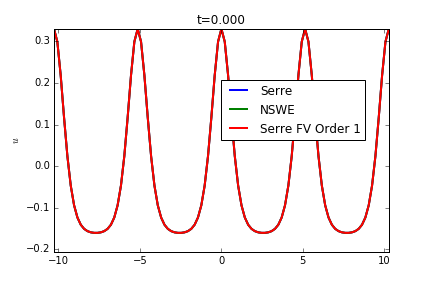
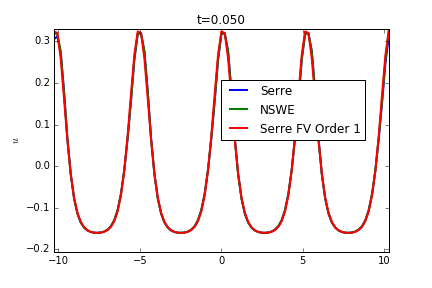
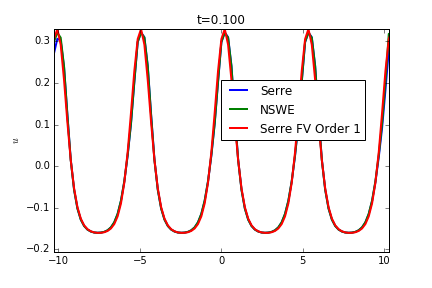
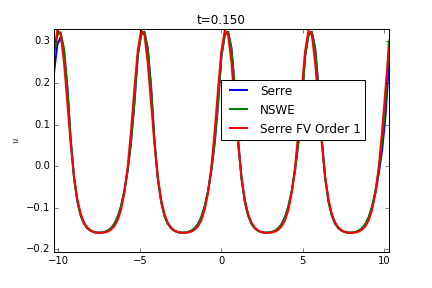
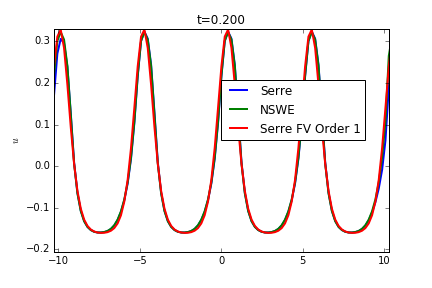
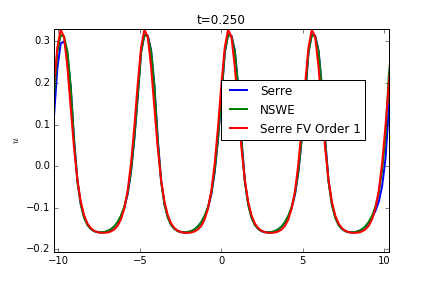
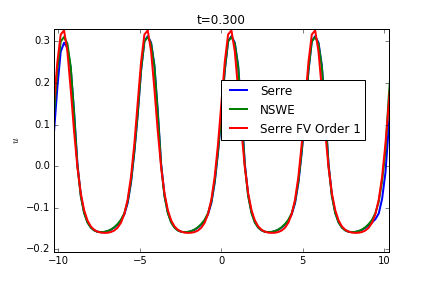
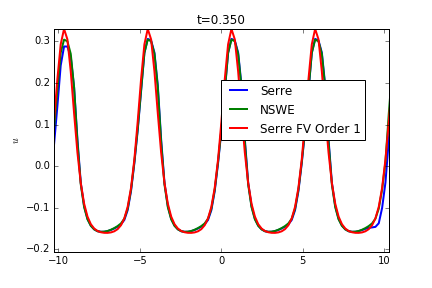
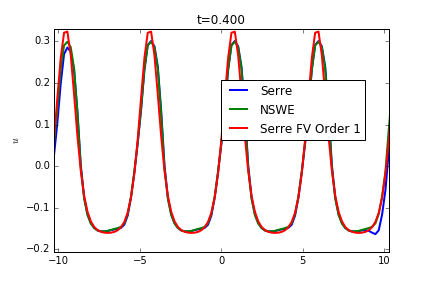
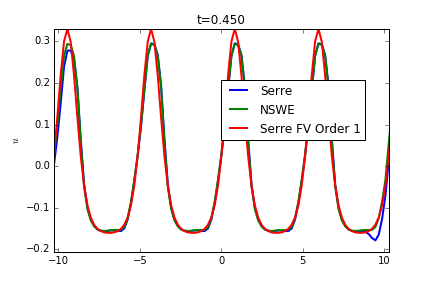
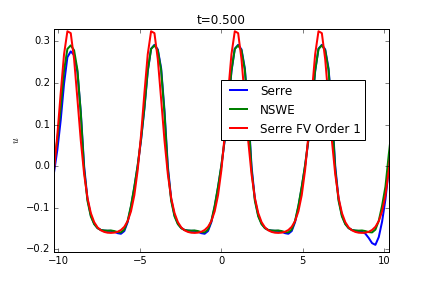
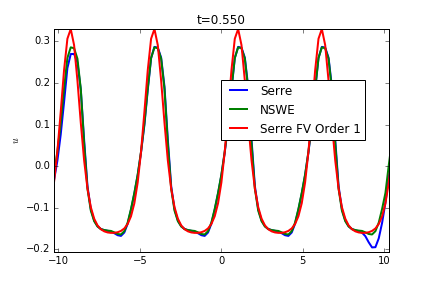
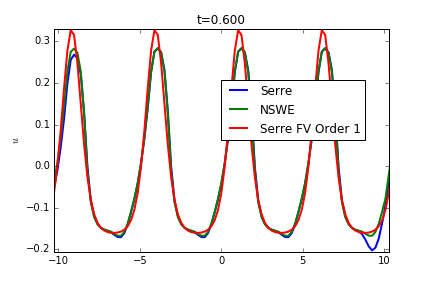
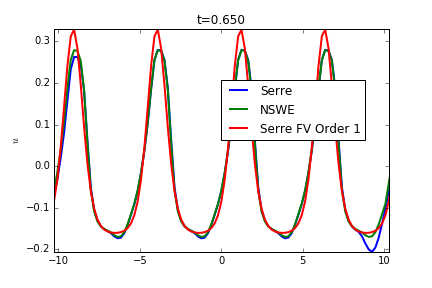
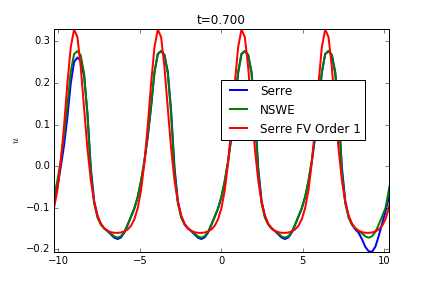
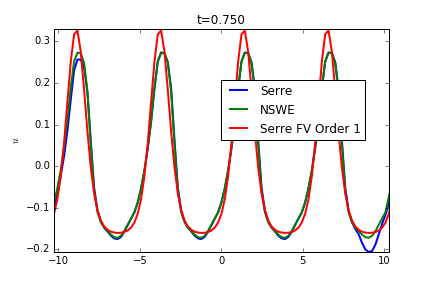
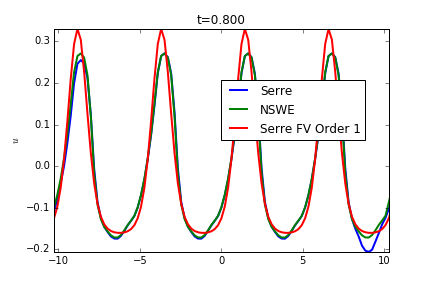
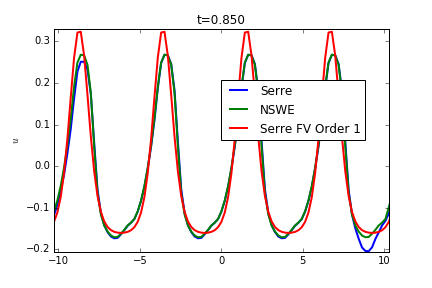
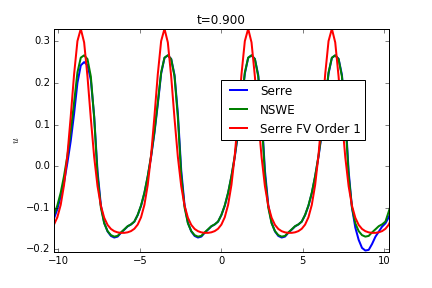
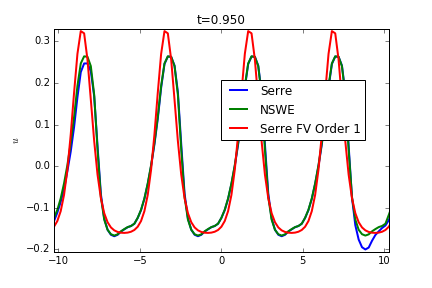
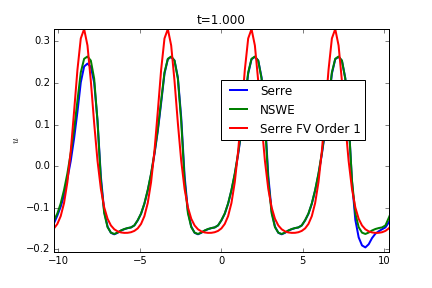
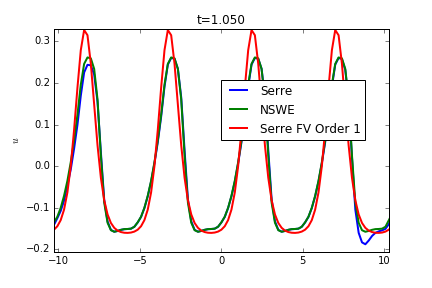
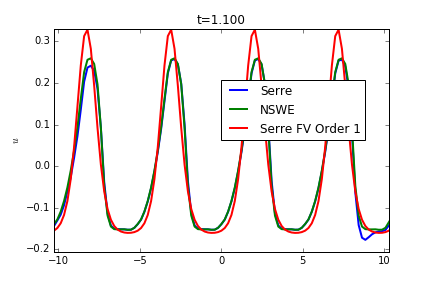
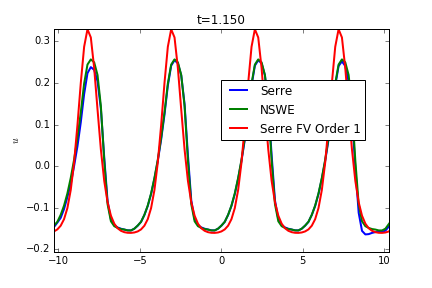
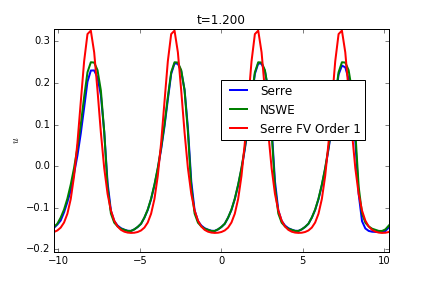
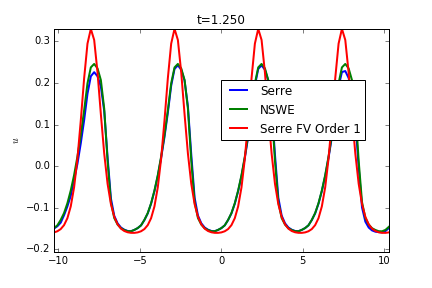
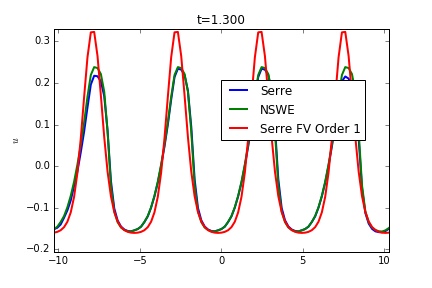
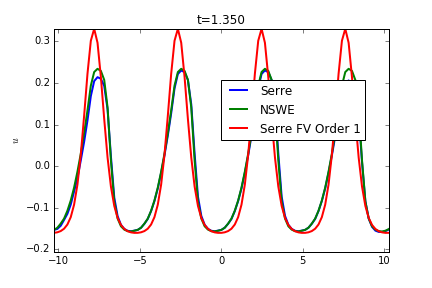
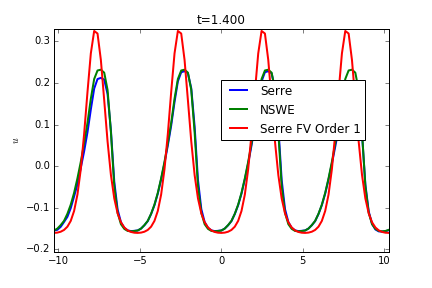
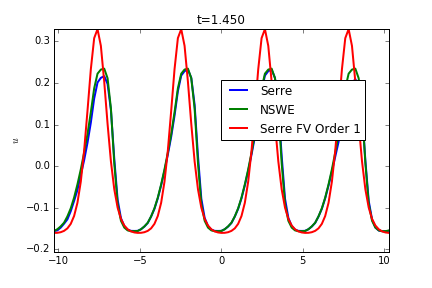
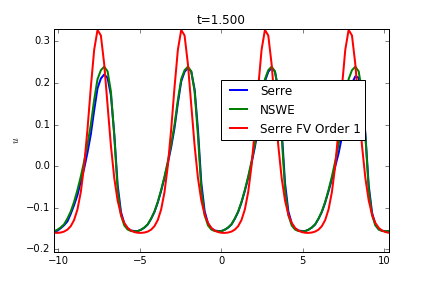
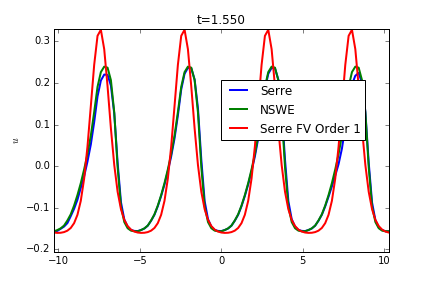
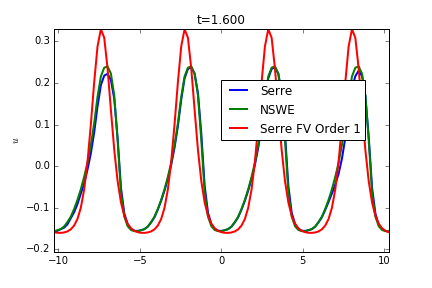
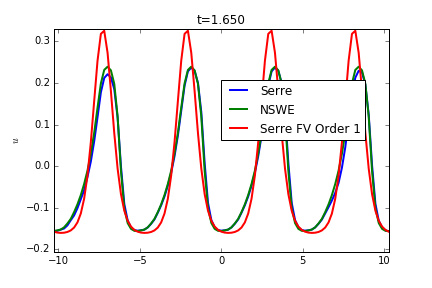
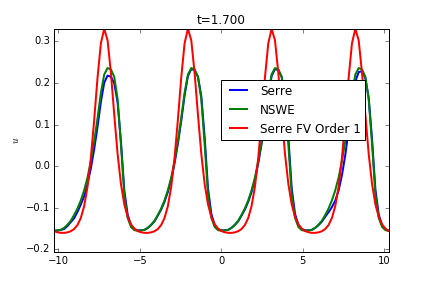
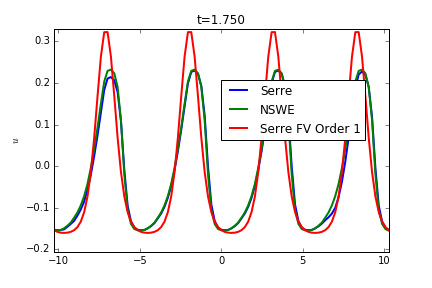
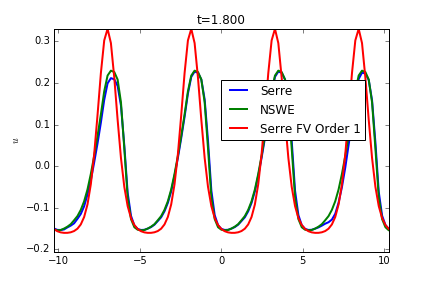
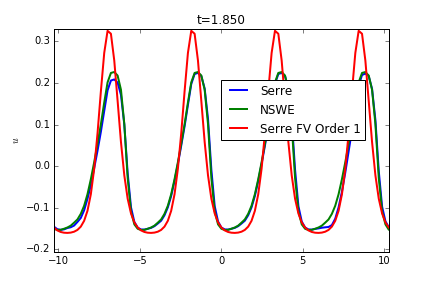
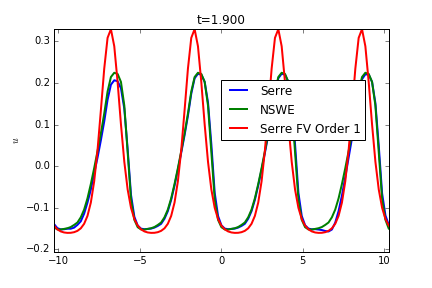
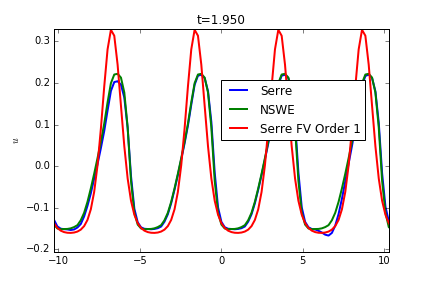
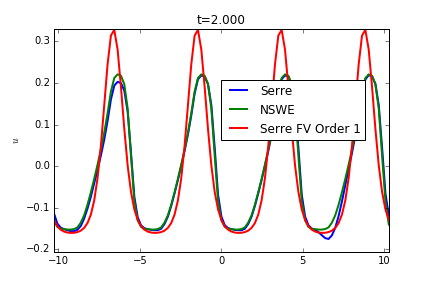
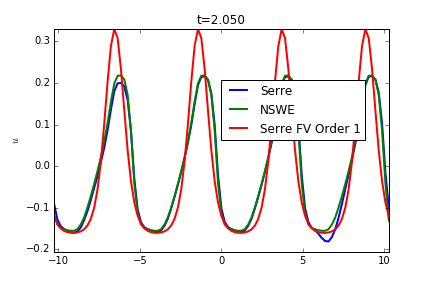
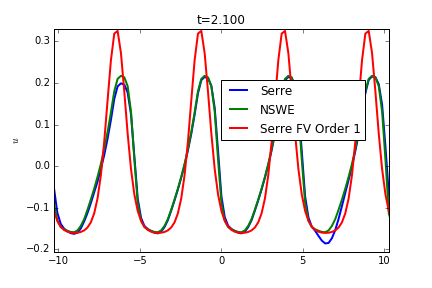
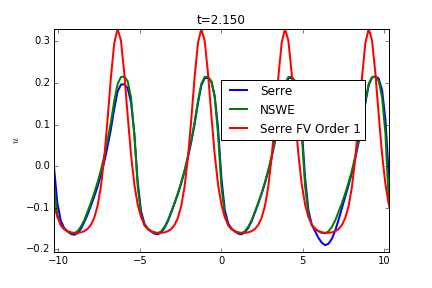
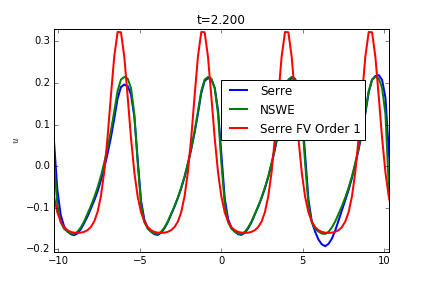
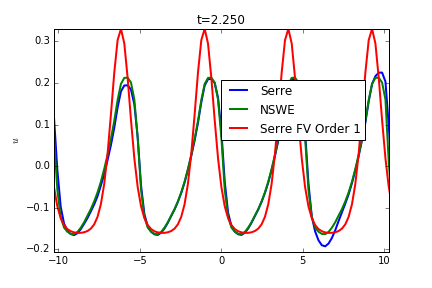
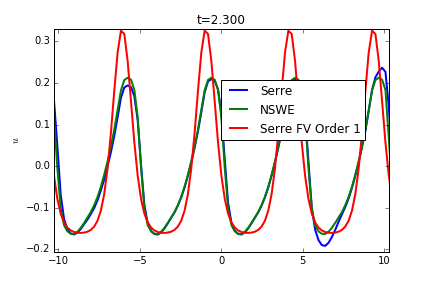
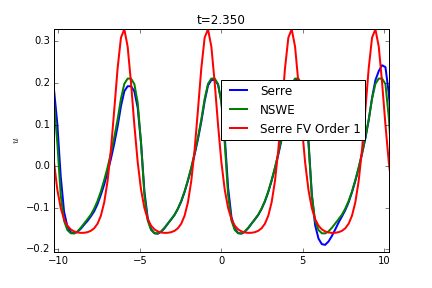
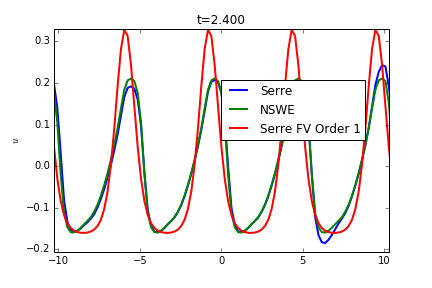
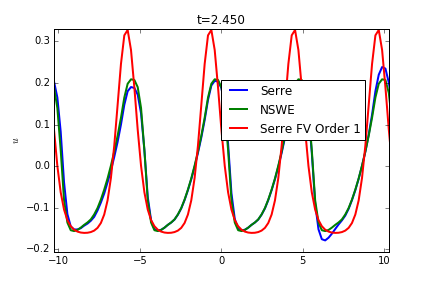
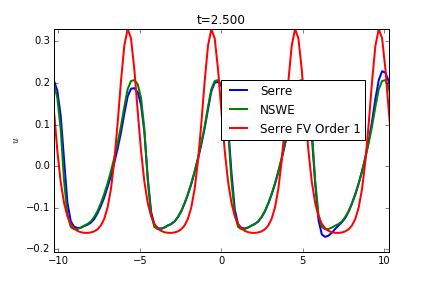
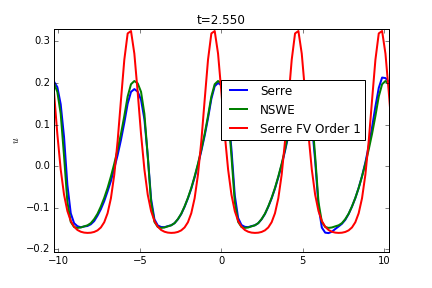
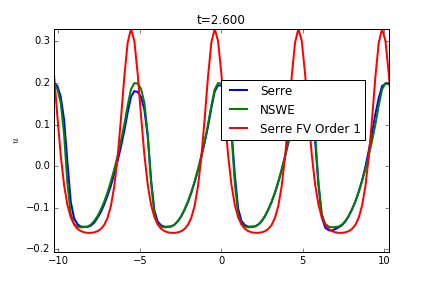
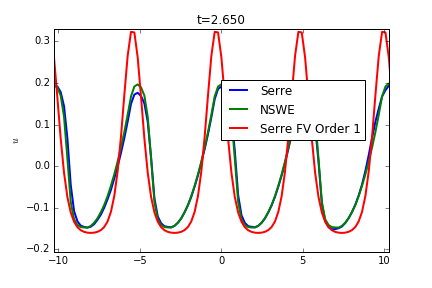
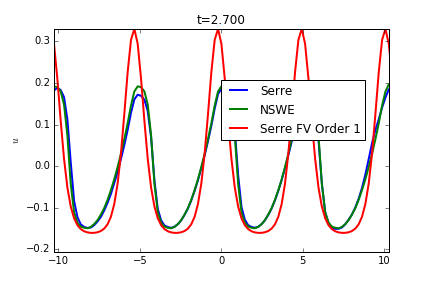
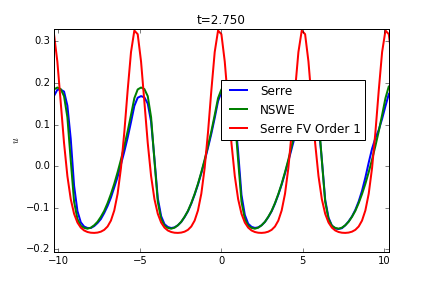
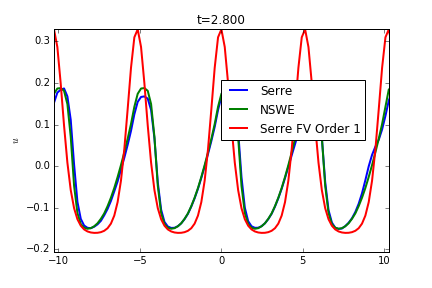
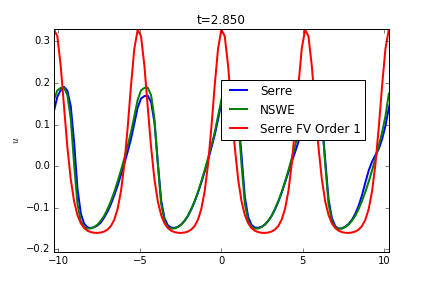
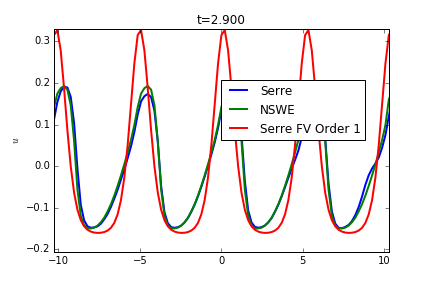
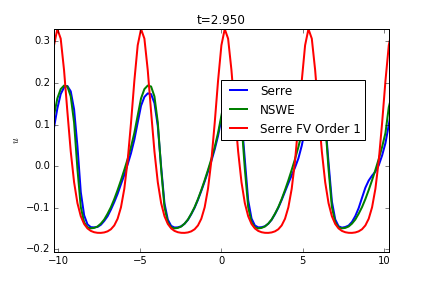
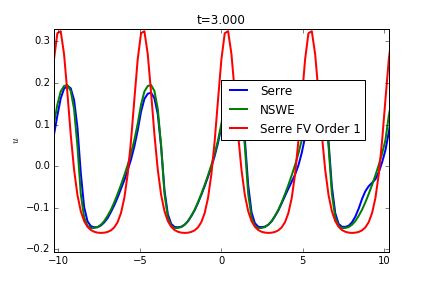
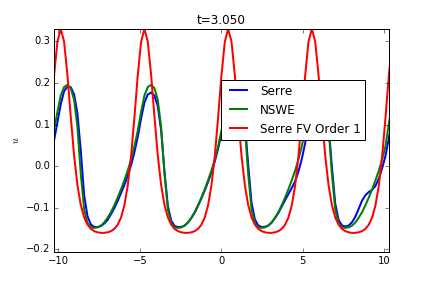
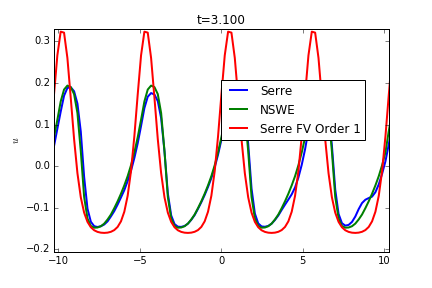
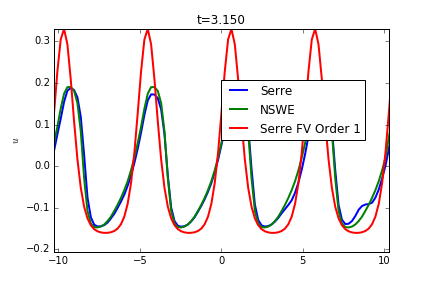
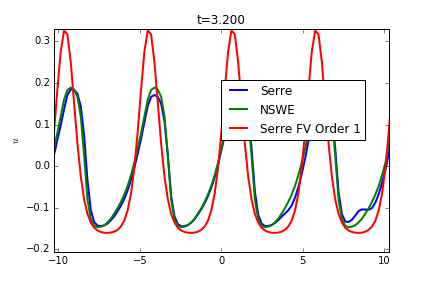
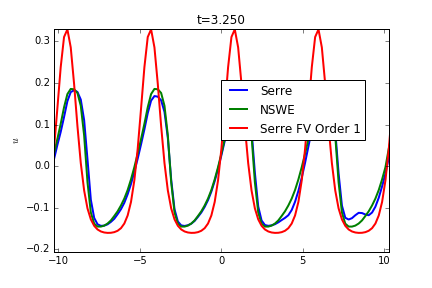
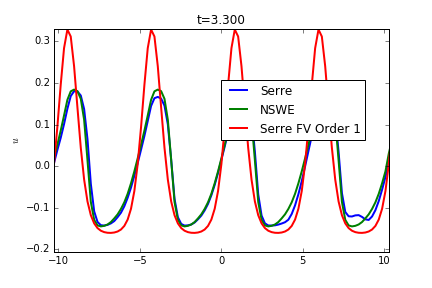
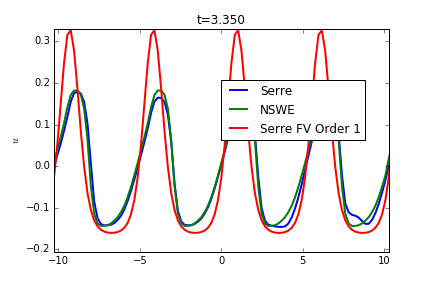
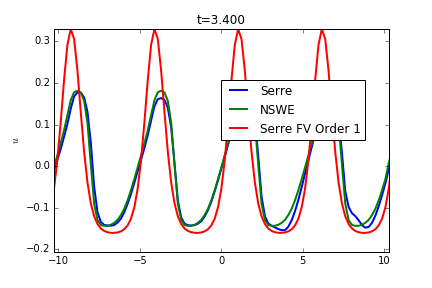
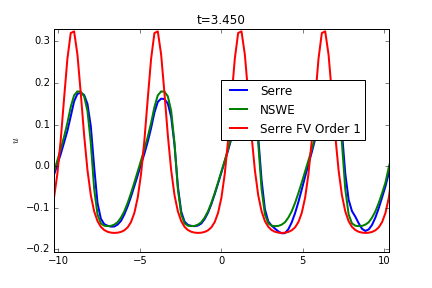
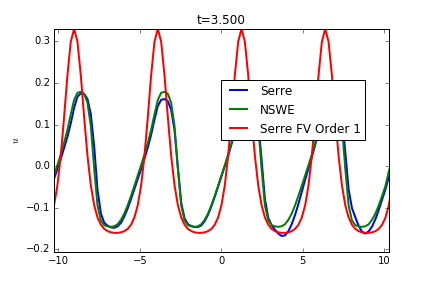
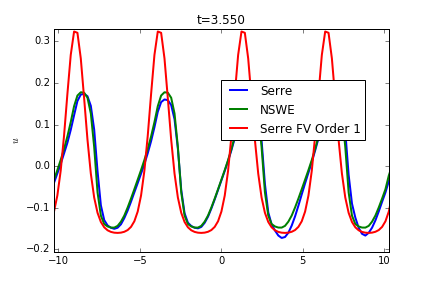
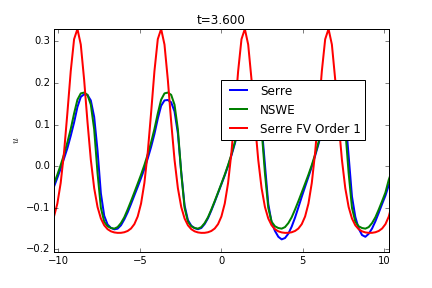
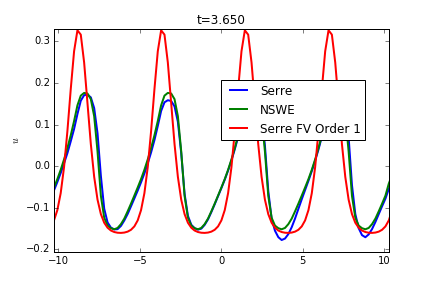
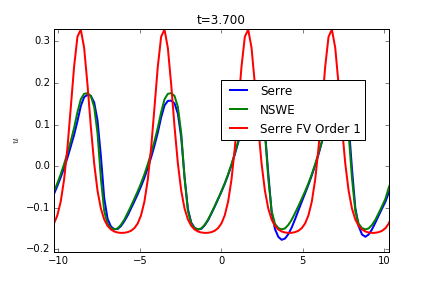
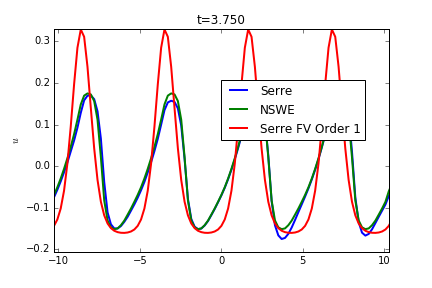
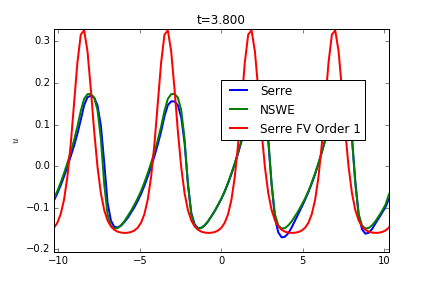
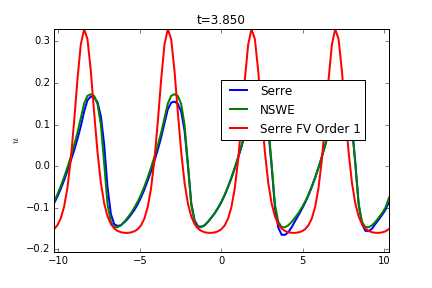
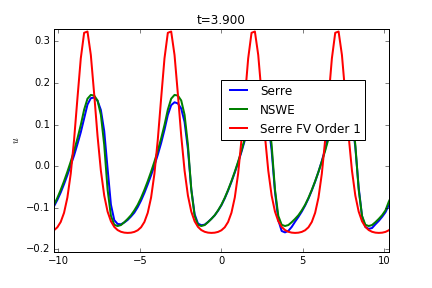
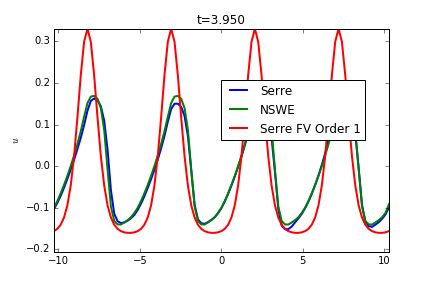
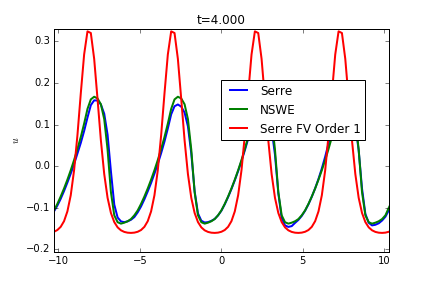
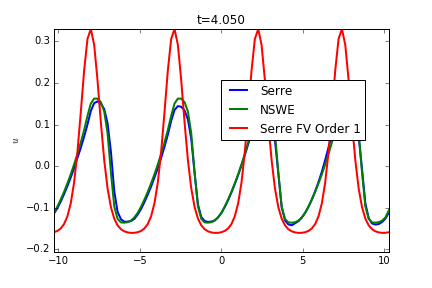
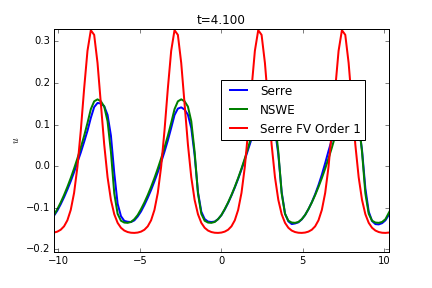
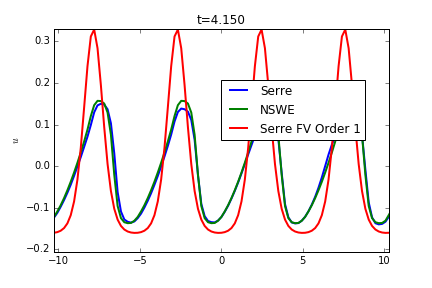
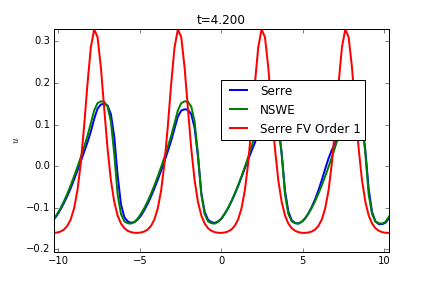
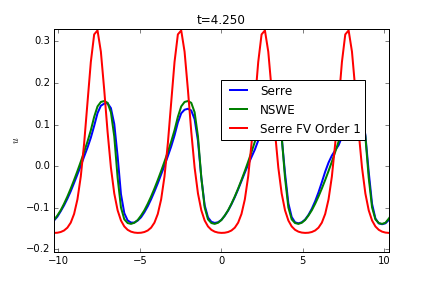
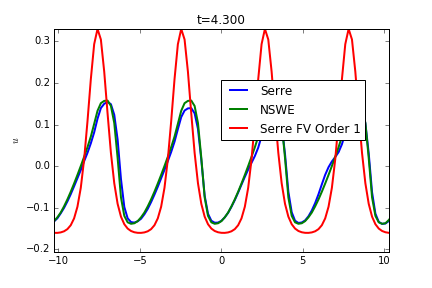
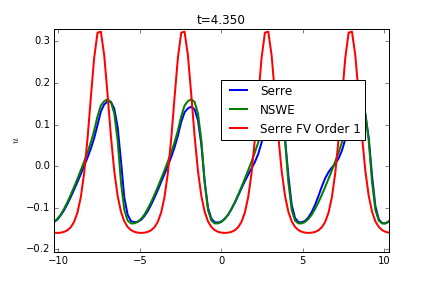
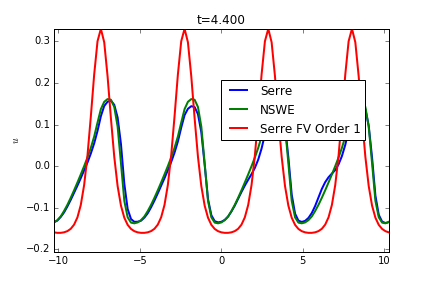
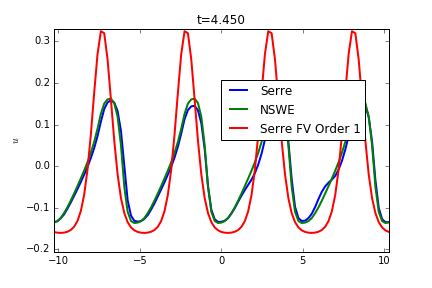
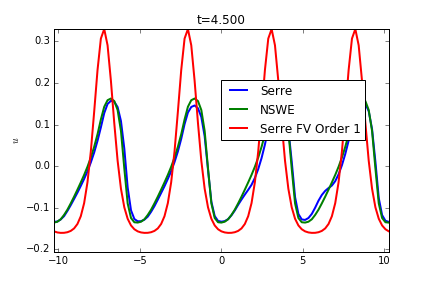
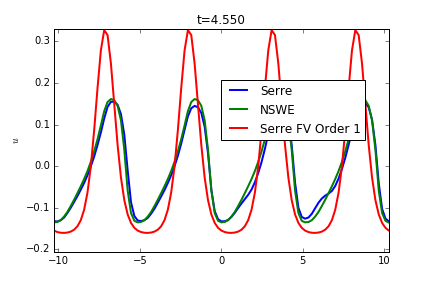
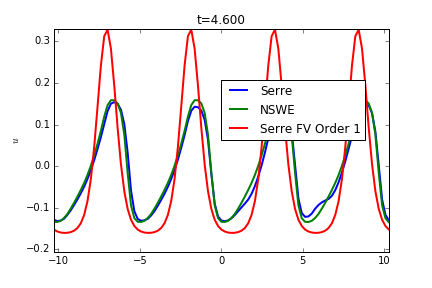
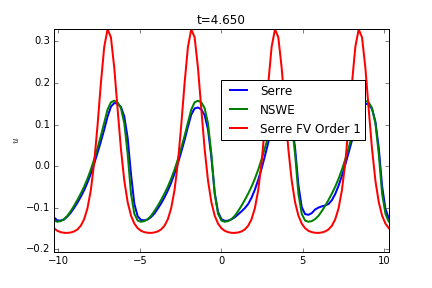
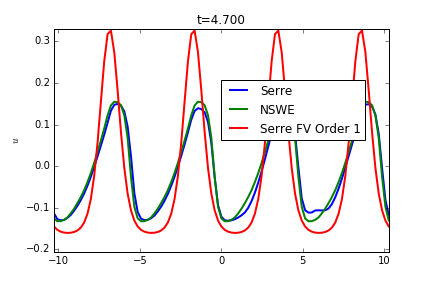
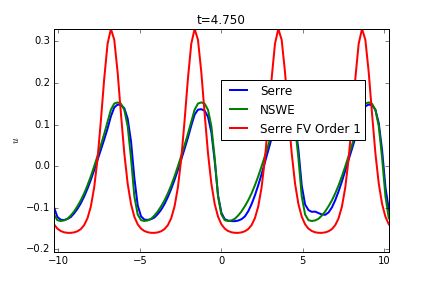
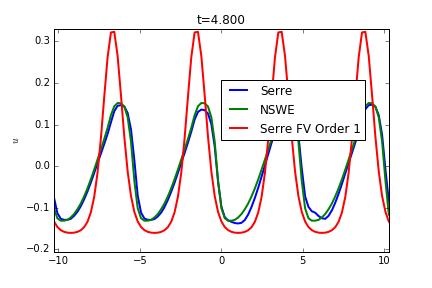
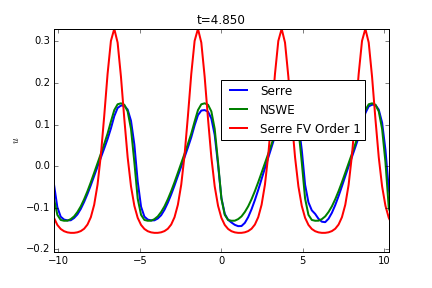
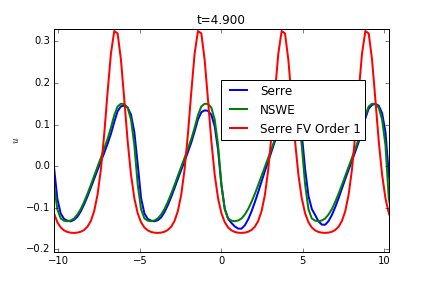
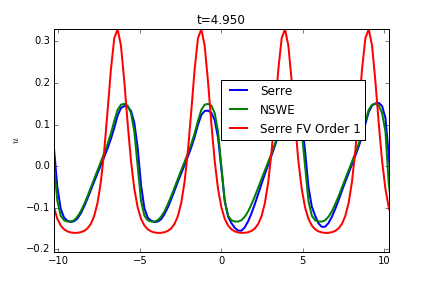
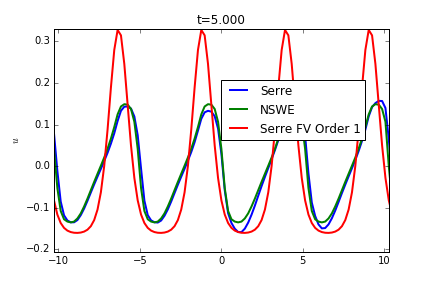
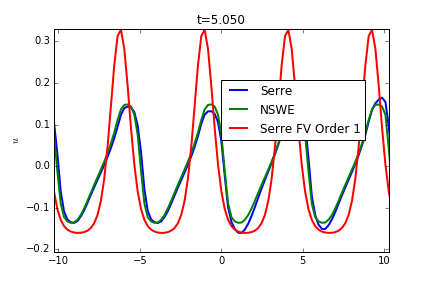
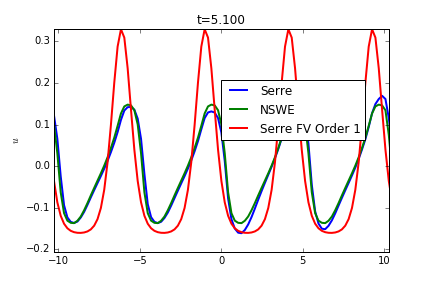
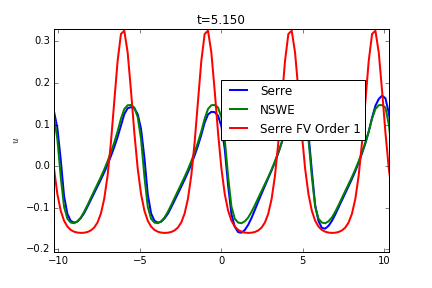
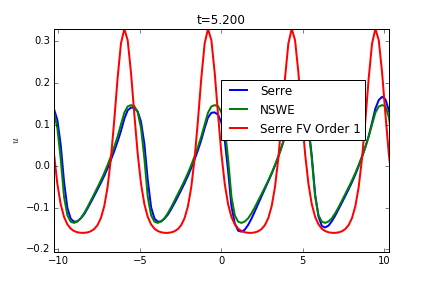
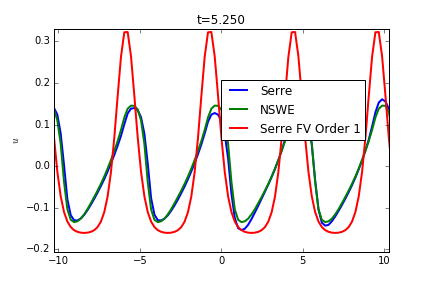
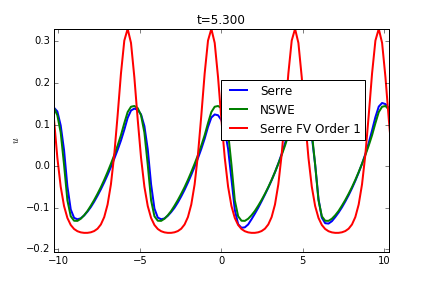
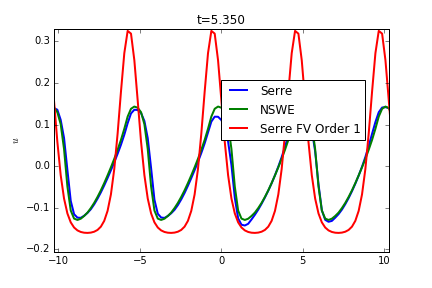
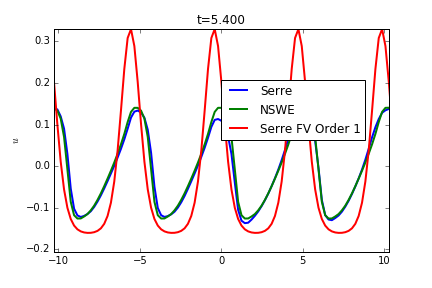
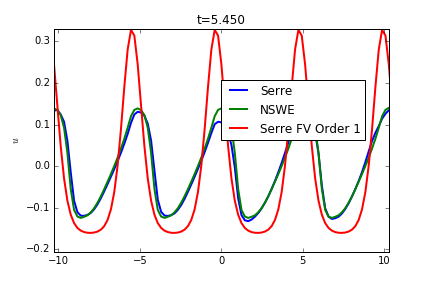
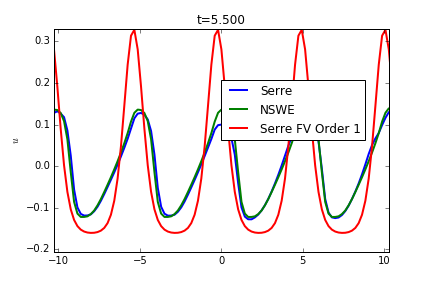
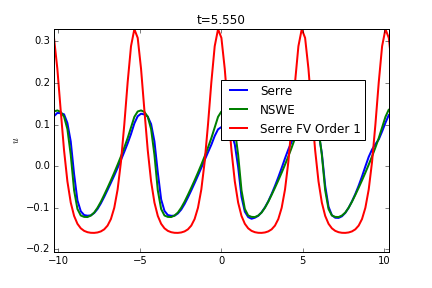
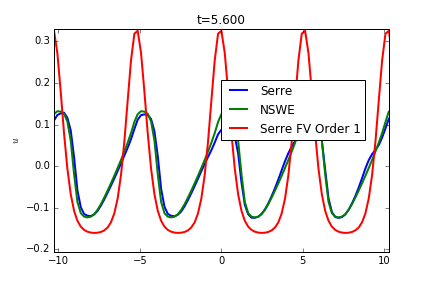
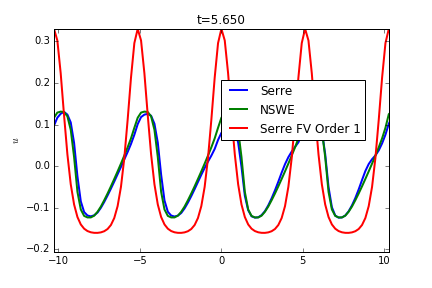
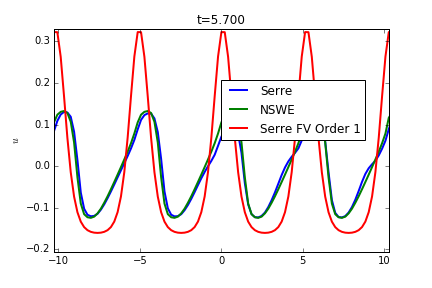
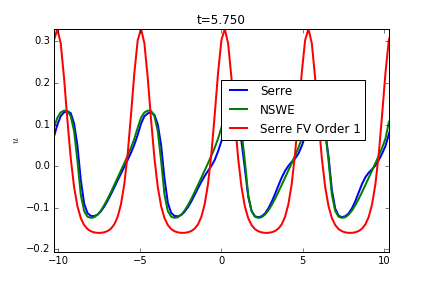
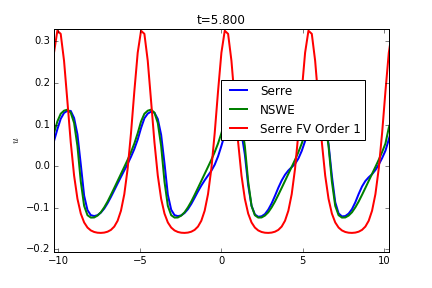
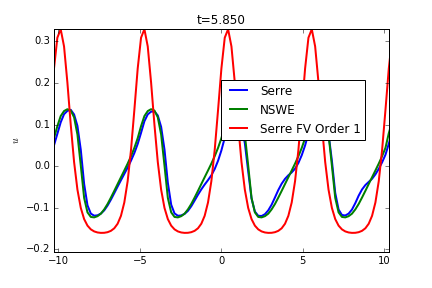
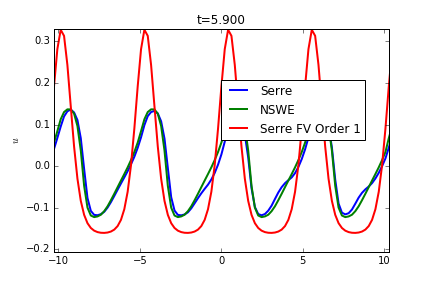
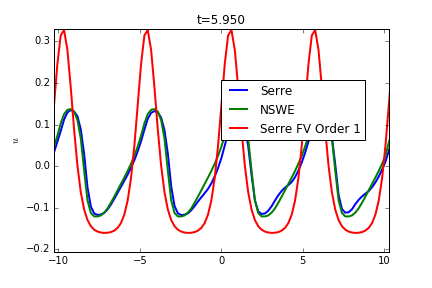
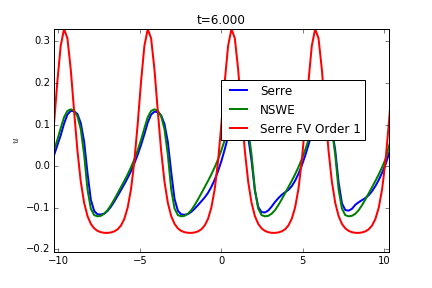
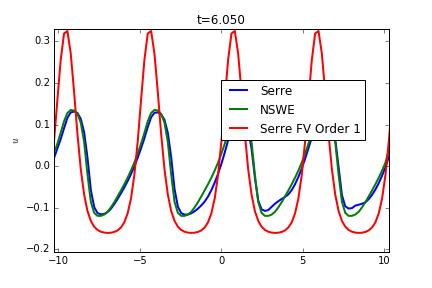
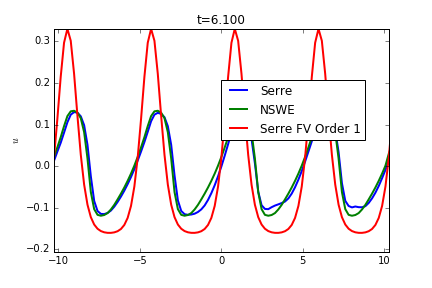
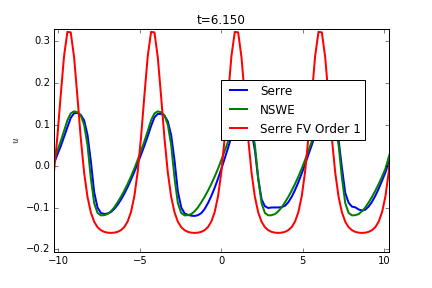
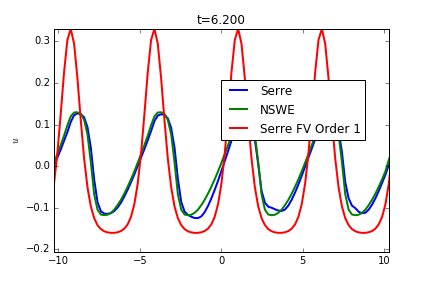
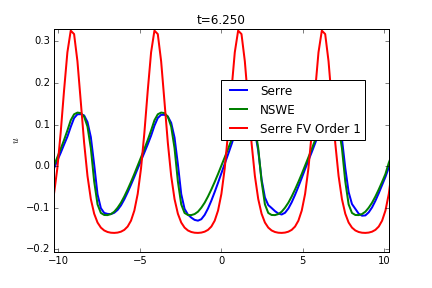
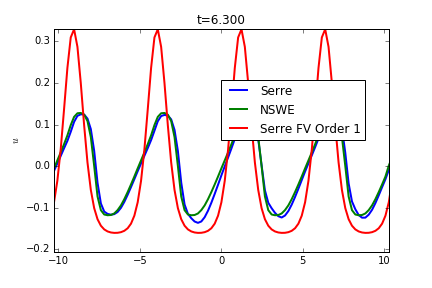
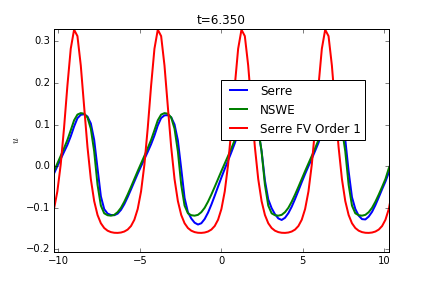
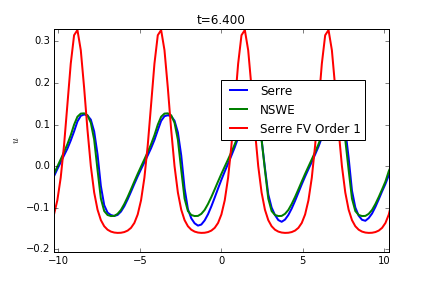
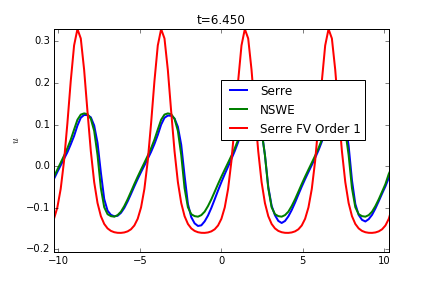
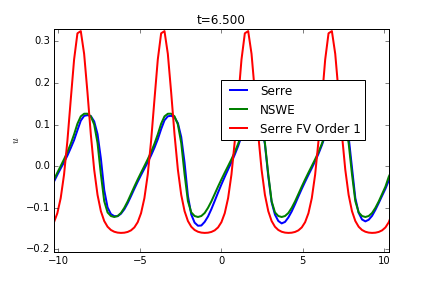
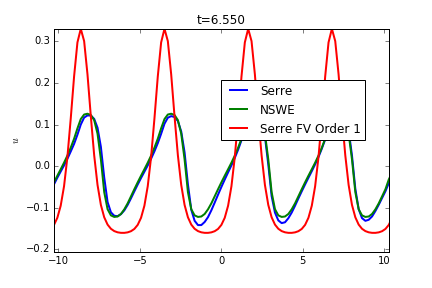
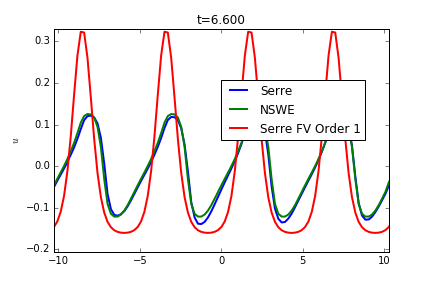
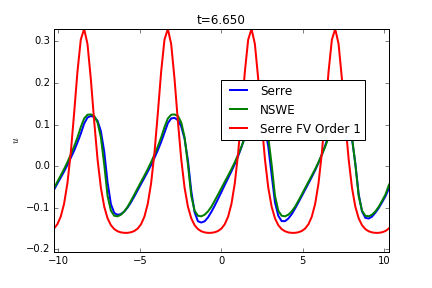
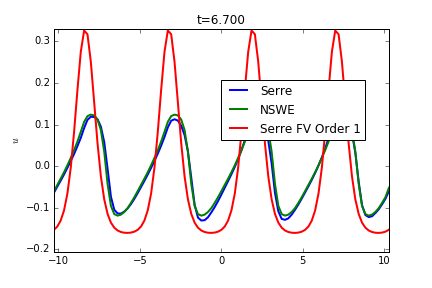
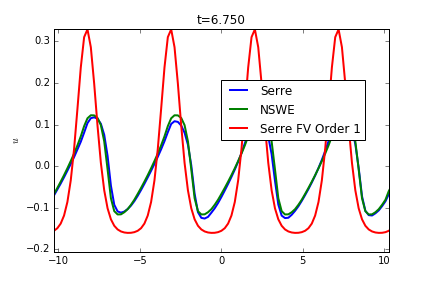
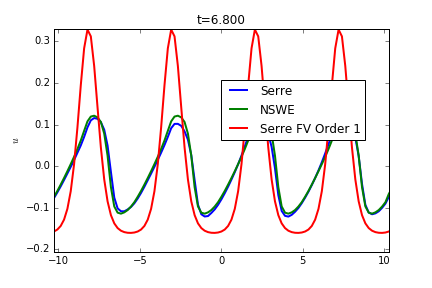
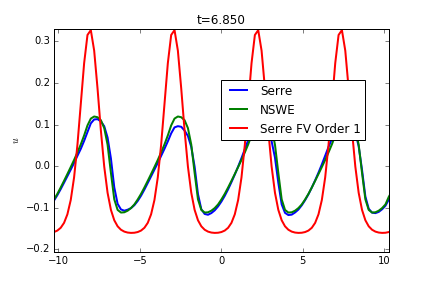
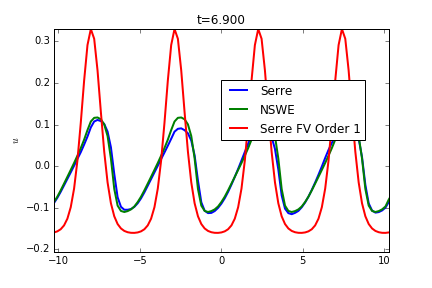
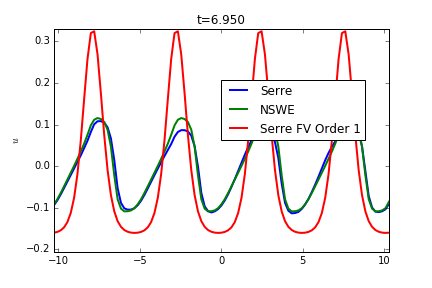
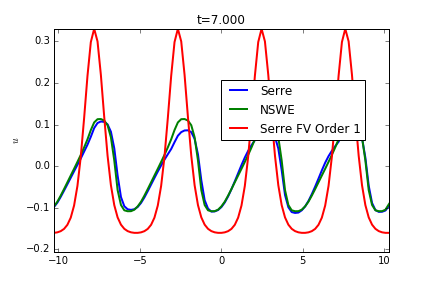
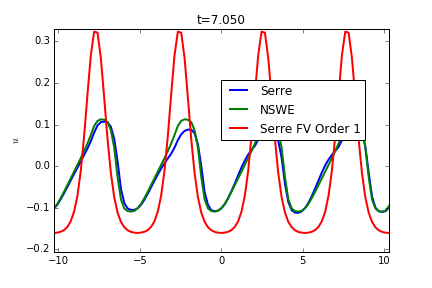
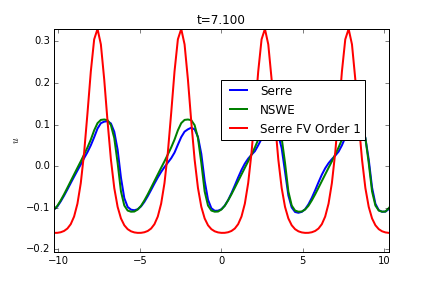
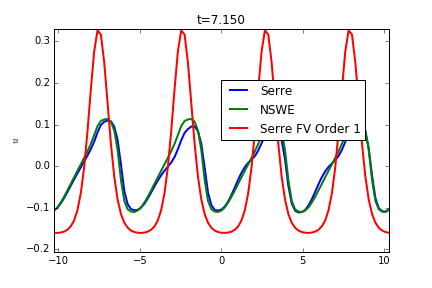
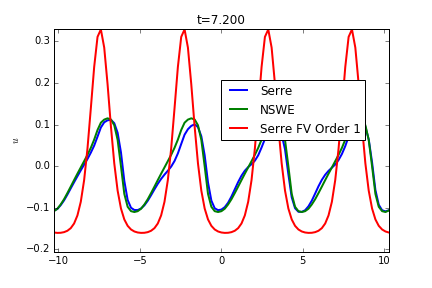
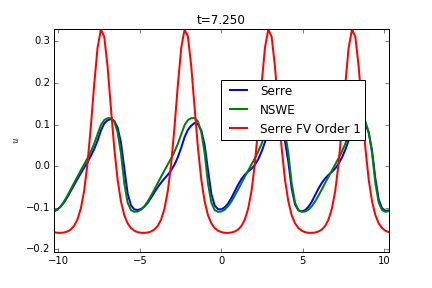
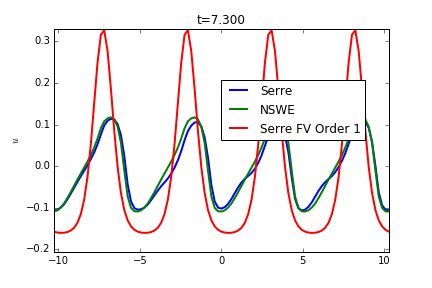
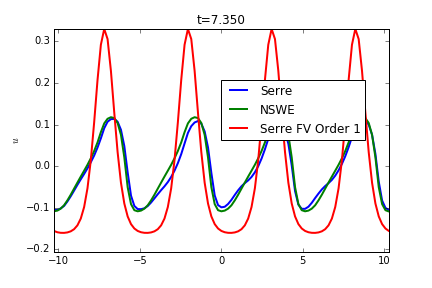
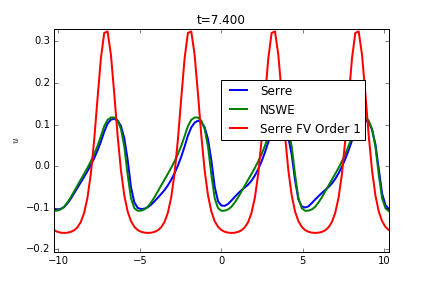
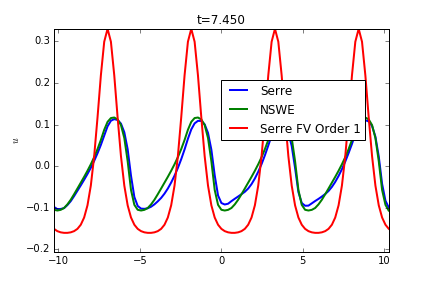
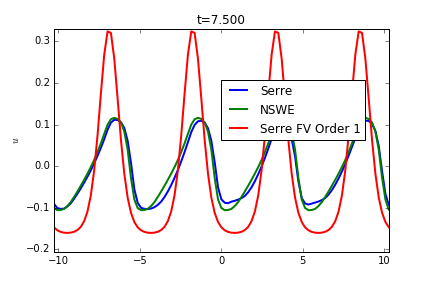
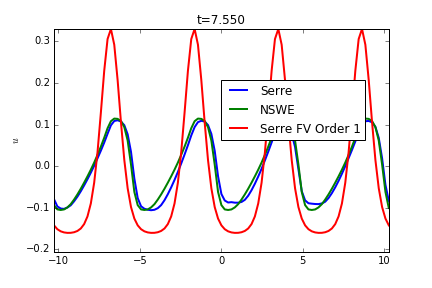
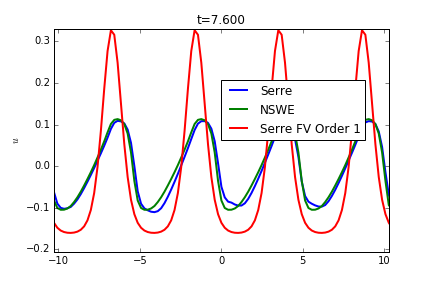
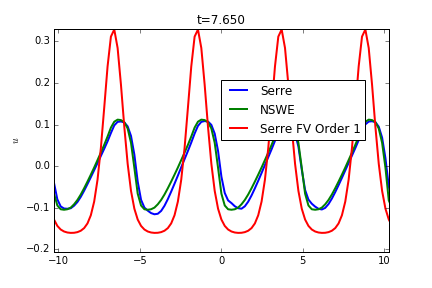
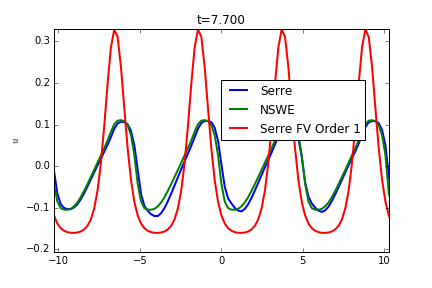
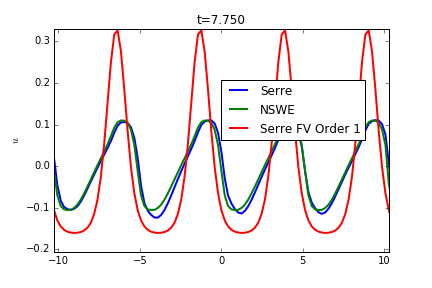
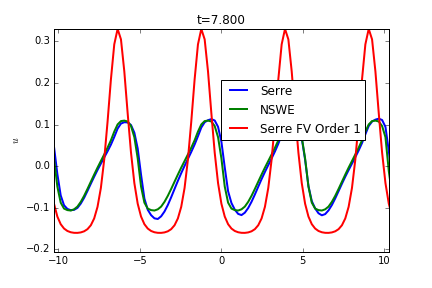
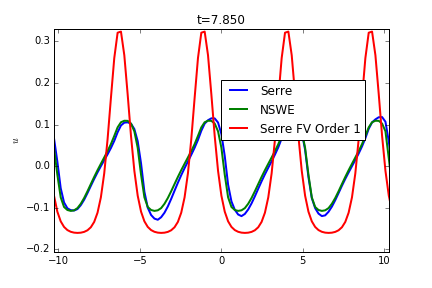
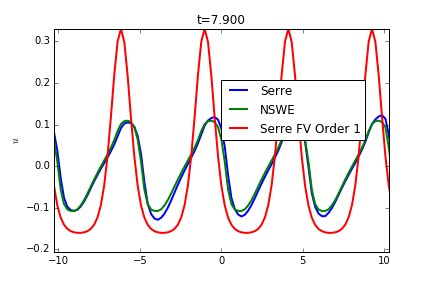
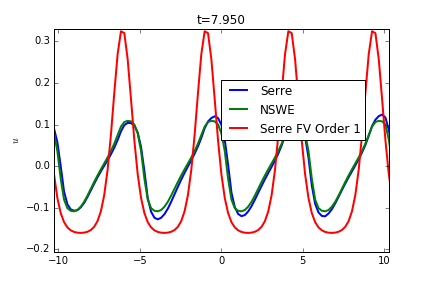
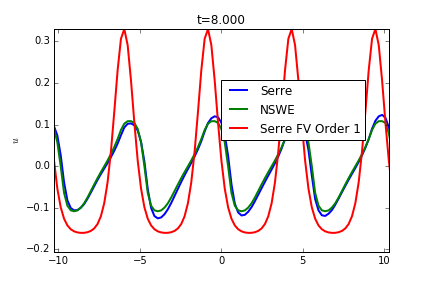
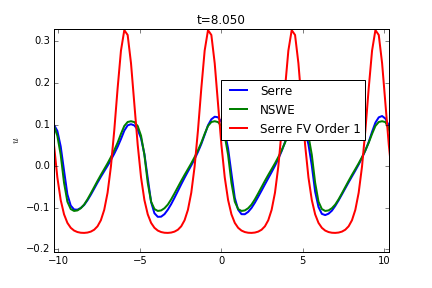
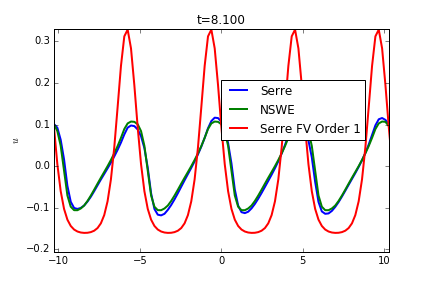
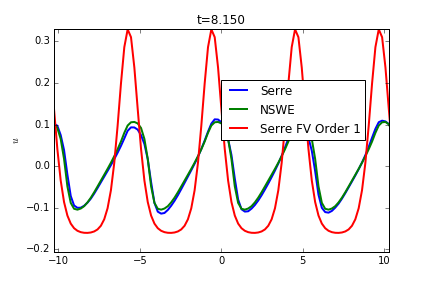
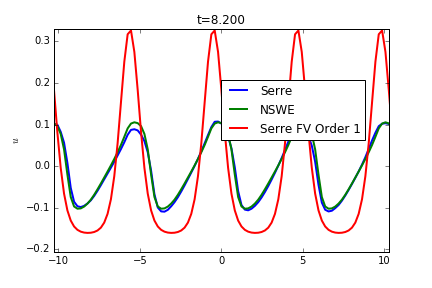
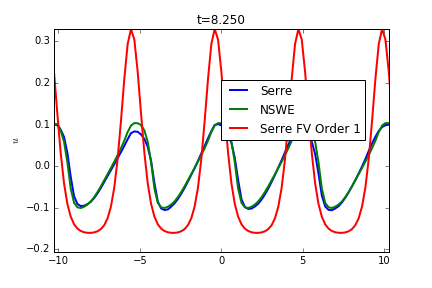
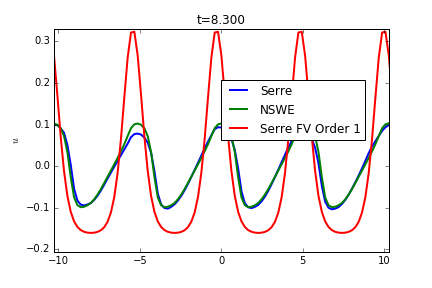
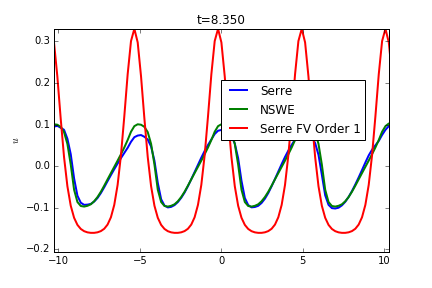
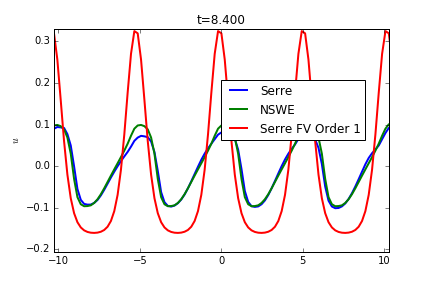
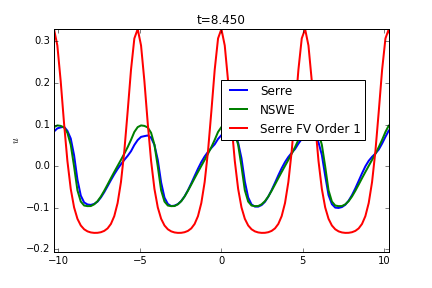
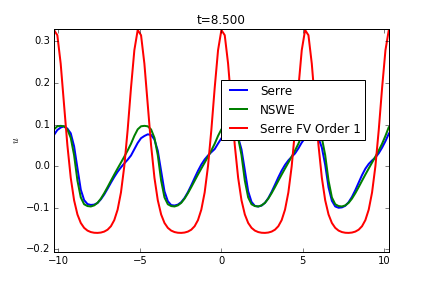
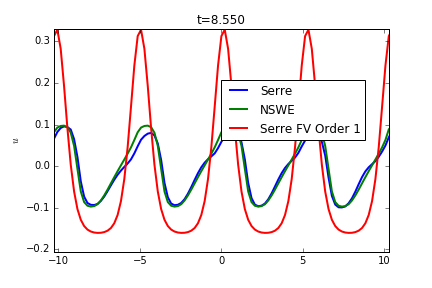
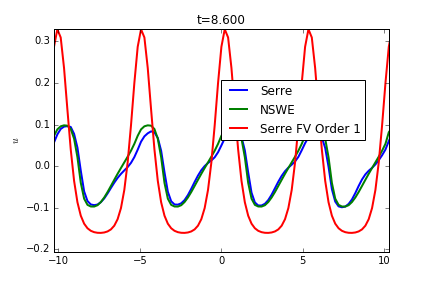
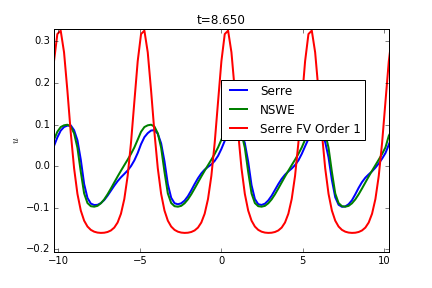
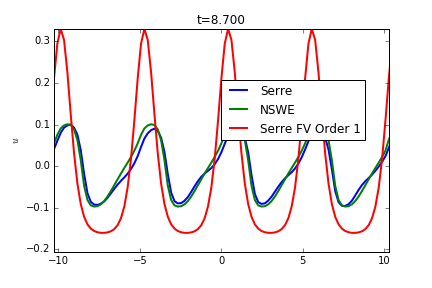
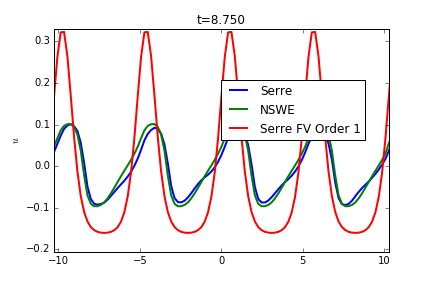
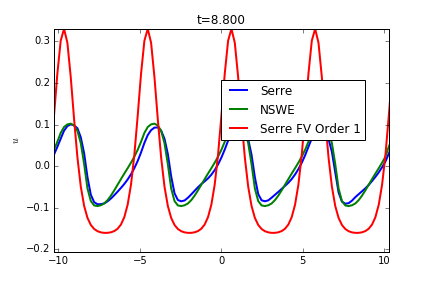
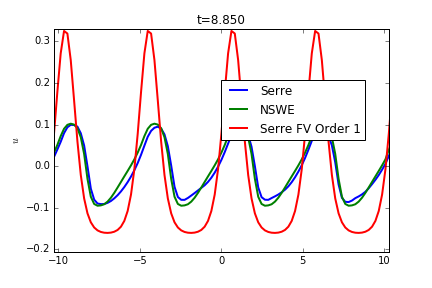
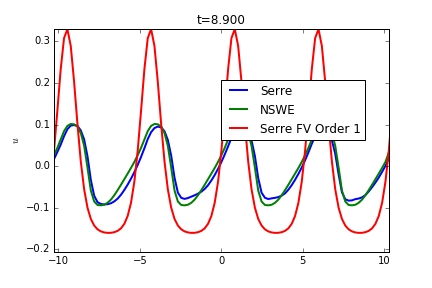
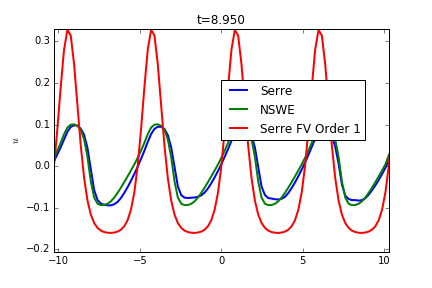
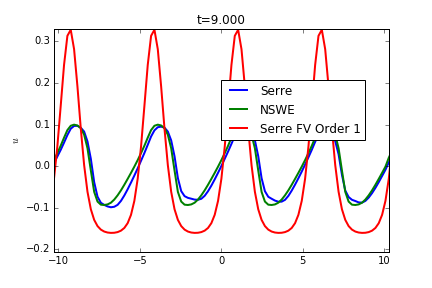
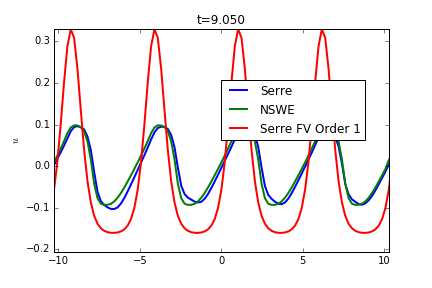
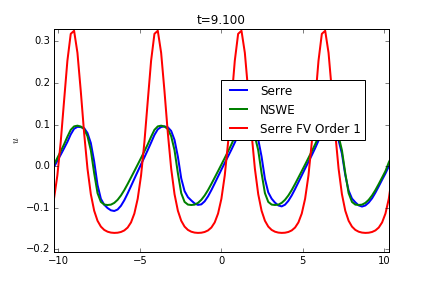
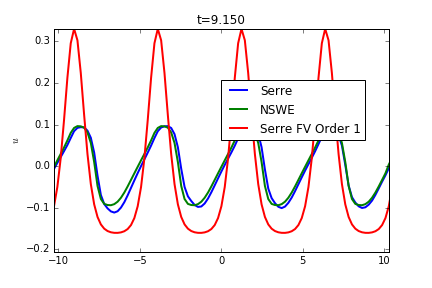
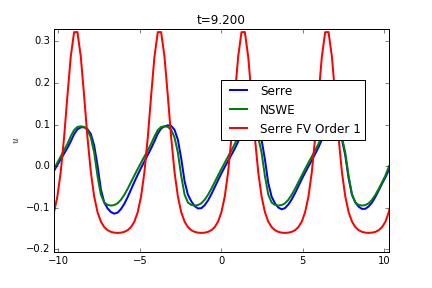
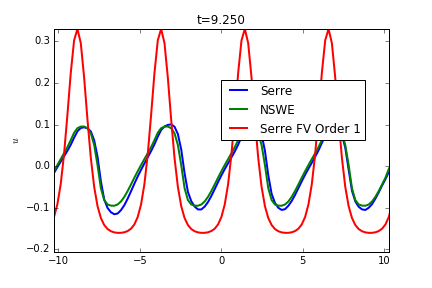
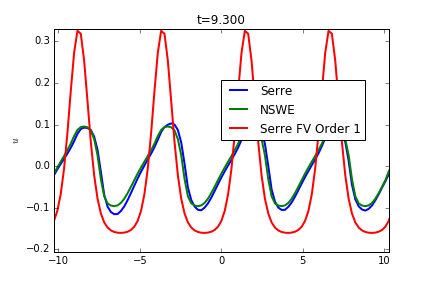
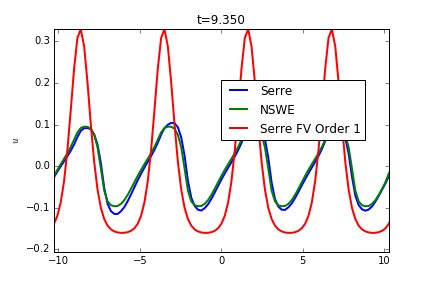
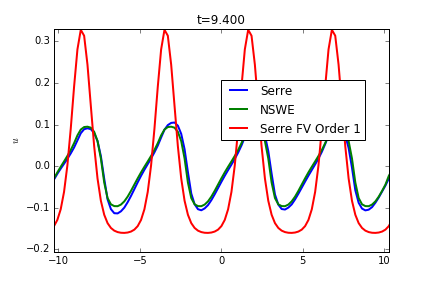
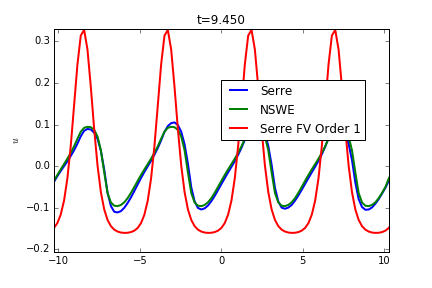
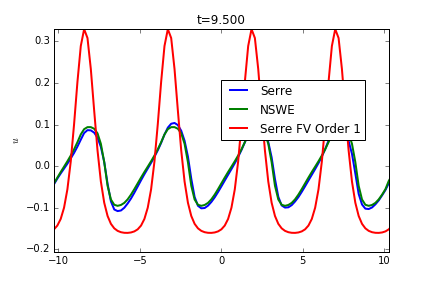
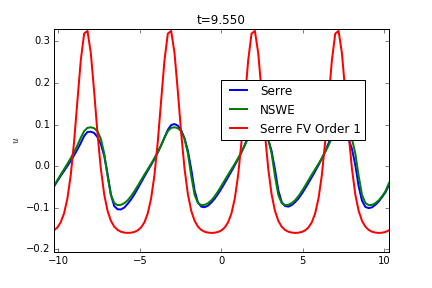
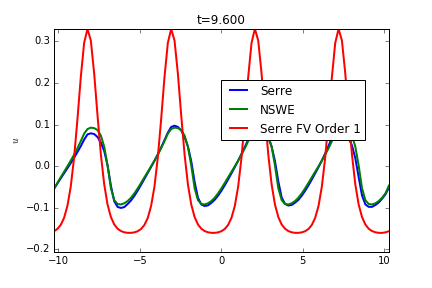
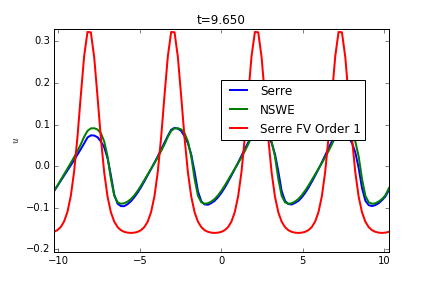
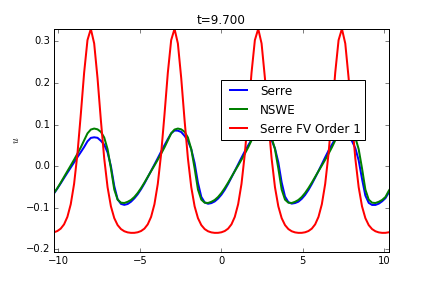
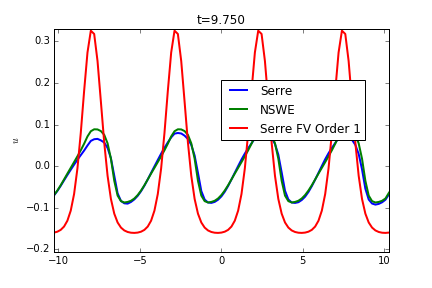
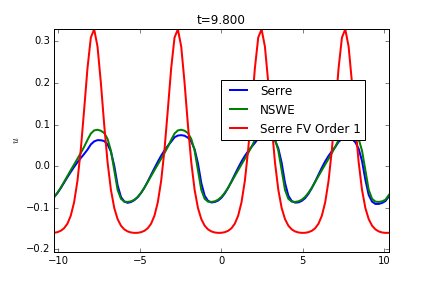
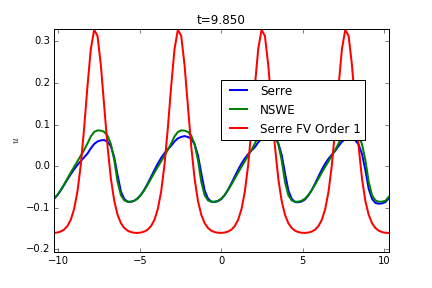
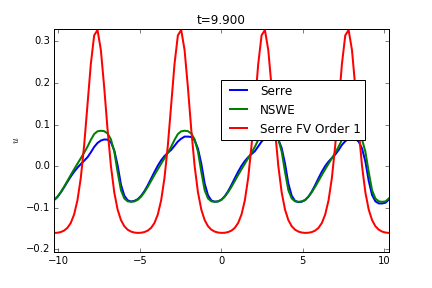
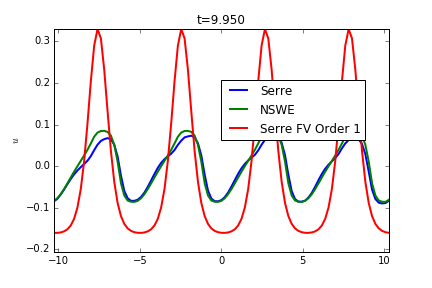
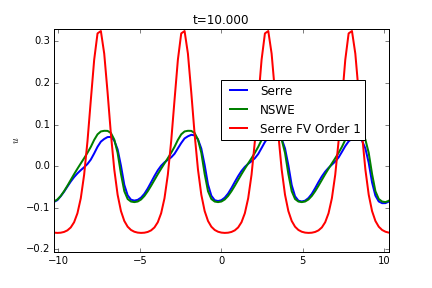

In [57]:
hallexact = np.copy(hall1)
uallexact = np.copy(uall1)

for i in range (tall1.size):
    hallexact[:,i],uallexact[:,i] = cnoidal.analyticalSolution(x,tall1[i],k,a0,a1)

lb = ["Serre","NSWE","Serre FV Order 1", "Analytical solution"]
gF.plotAnimationNSolutions(3,x,np.array([uall1,uall2,uallexact]),tall1,xmin,xmax,umin,umax,lb,ylabel=r'$u$')

In [53]:
gF.plotAnimationNSolutions(4,x,np.array([hall1,hall2,hall3,hallexact]),tall1,xmin,xmax,hmin,hmax,lb,ylabel=r'$h$')

*** Plotting animation ...


IndexError: too many indices for array

### Test 5 : analytical solution (Rayleigh solitary wave)

#### Some remarks and conclusions concerning the results presented below

* Similarly to the results given with the cnoidal solution as initial condition, the tests with the Rqyleigh solitary wave didn't presented the expected analytical result. In fact, we observe the formation of secondary waves, instead of the conservation of the wave shape.
* The similarity of the results given by the Serre equations and by the NSWE is even strong than the case of the cnoidal waves.

In [58]:
#### First and second simulations : done with muscl2 (so two ghost cells) --> ok
#### Third simulation : done with order1 in advection (so one ghost cells)
    
a0 = .3
a1 = .1
k = 0.
g = 9.81
t = 0.0

lam, h0 = cnoidal.WaveLengthDepth(k,a0,a1)


L = 10.*lam
xmin = -L
xmax = 3.*L
nx = 100

x,dx = serre.discretizeSpace(xmin,xmax,nx)

h,u = cnoidal.analyticalSolutionSolitary(x,t,a0,a1)


u2 = np.copy(u)
h2 = np.copy(h)
u3 = np.copy(u)
h3 = np.copy(h)

BC1=np.array([0.,0.,0.,0.,0.,1.,0.,1.,0.,1.,0.,1.,0.])
BC2=np.array([0.,0.,nan,nan,0.,nan,nan,nan,0,0,0,0.,0.,0,nan,nan])


hall1,uall1,tall1 = serre.splitSerre(x,h,u,0,2.,serre.periodicDomainTwoGC,
                                     serre.periodicDomain2,None,None,dx,nx,vardt = False, dt = 0.05, splitSteps=3,
                                     order=2, fvsolver = muscl2.fluxes2, fdsolver = serre.EFDSolverFM)
hall2,uall2,tall2 = serre.NSWE(x,h2,u2,0,2.,serre.periodicDomainTwoGC,None,dx,nx,vardt = False, dt = 0.05)
hall3,uall3,tall3 = serre.splitSerre(x,h3,u3,0,2.,serre.periodicDomain,
                                     serre.periodicDomain2,BC1,BC2,dx,nx,vardt = False, dt = 0.05, splitSteps=3,
                                     order=2, fvsolver=nswe.fluxes, fdsolver=serre.EFDSolverFM, ghostcells=1)

umin = np.amin(np.concatenate((uall1,uall2,uall3)))
umax = np.amax(np.concatenate((uall1,uall2,uall3)))
hmin = np.amin(np.concatenate((hall1,hall2,hall3)))
hmax = np.amax(np.concatenate((hall1,hall2,hall3)))

print(np.linalg.norm(uall1-uall2))
print(np.linalg.norm(hall1-hall2))

CFL = 0.049212
CFL = 0.049212
CFL = 0.049212


serre.py:725: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  


0.00394911550176
0.000656587667037


*** Plotting animation ...



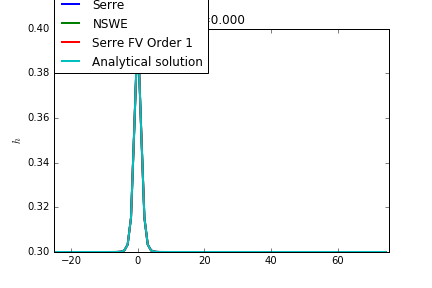
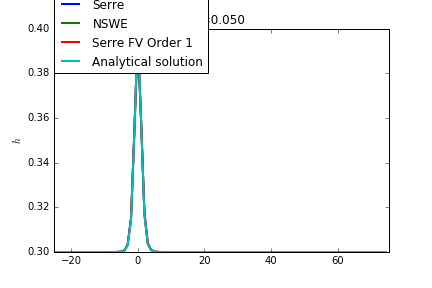
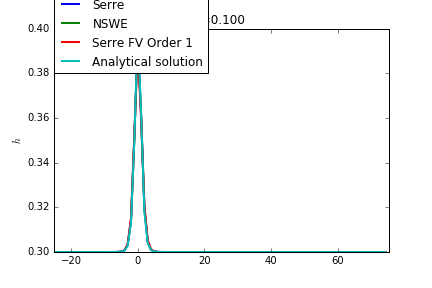
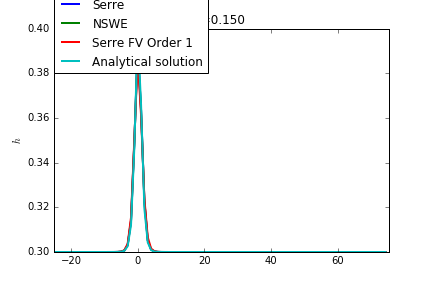
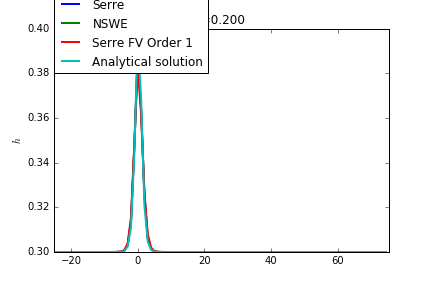
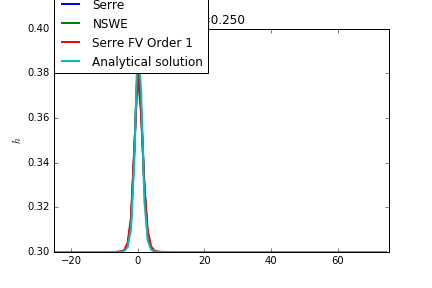
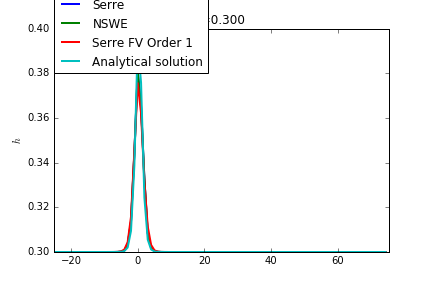
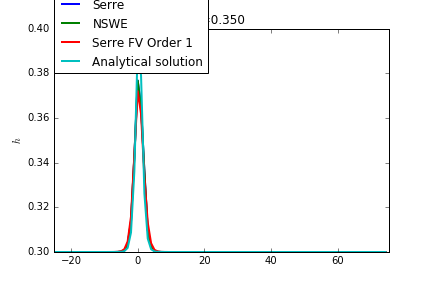
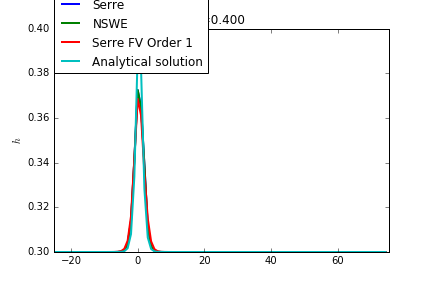
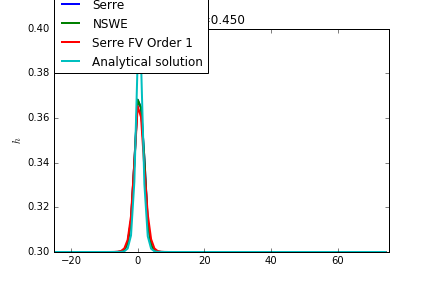
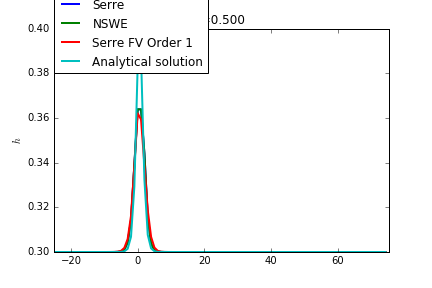
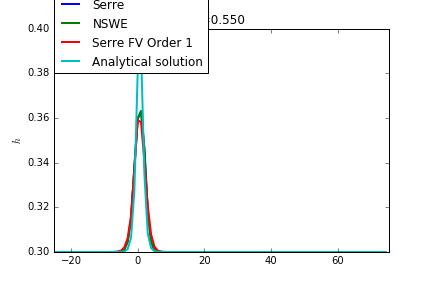
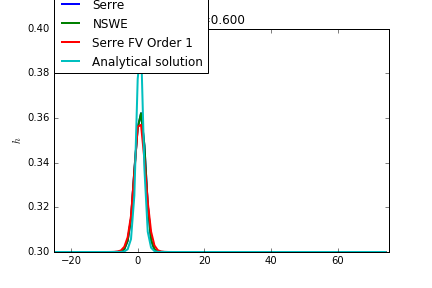
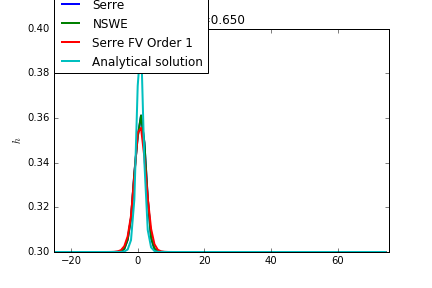
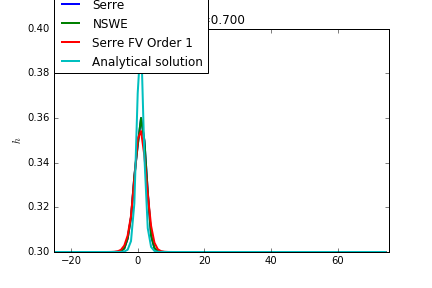
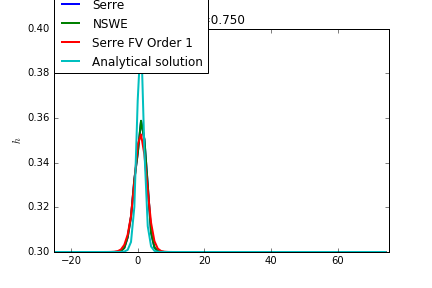
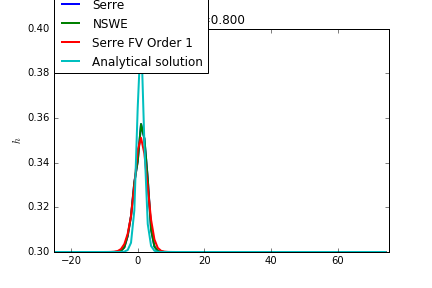
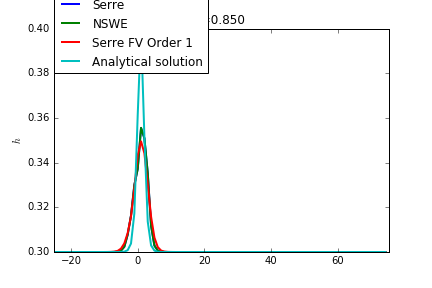
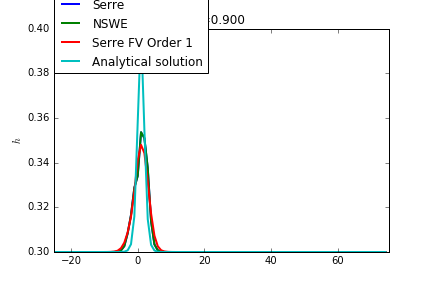
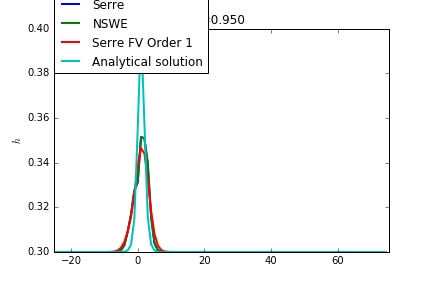
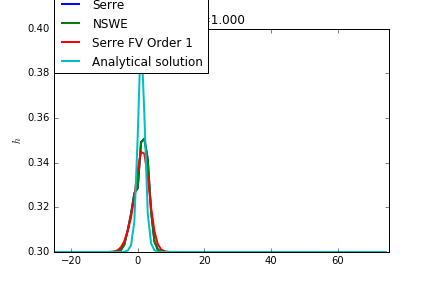
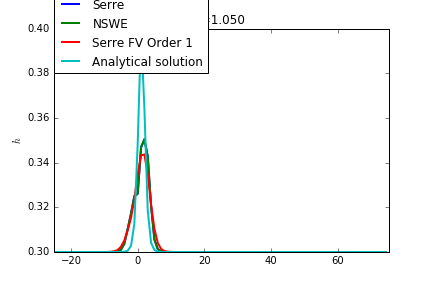
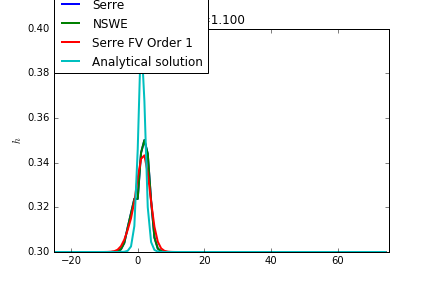
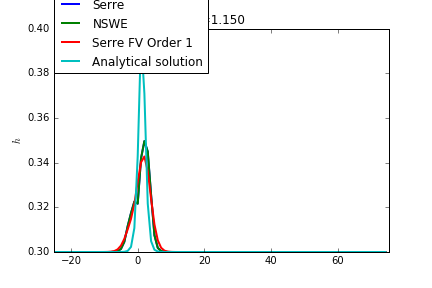
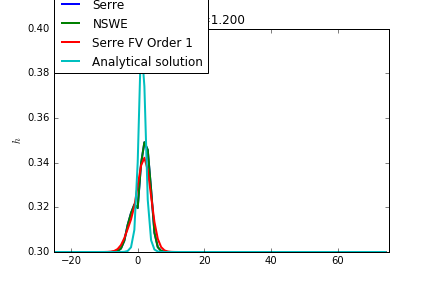
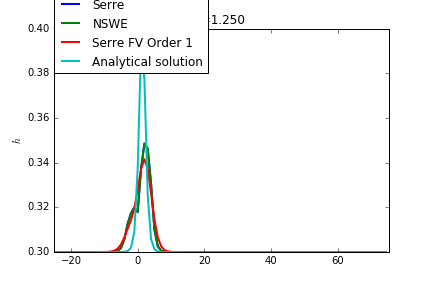
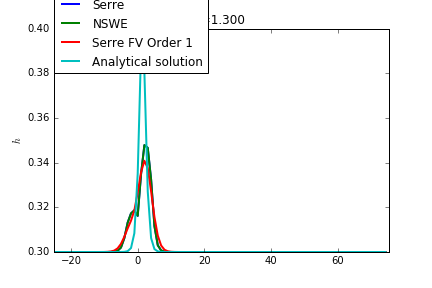
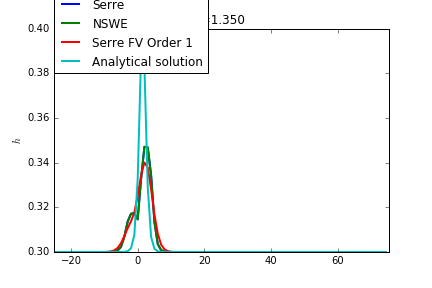
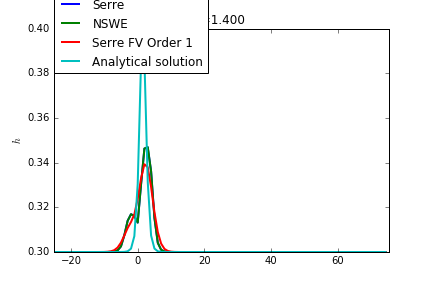
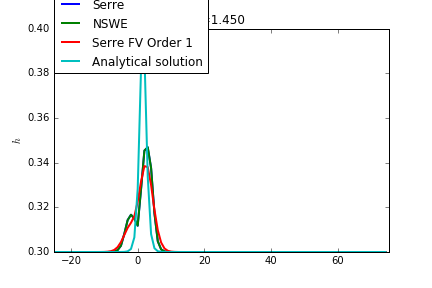
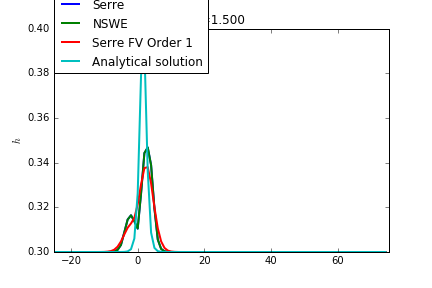
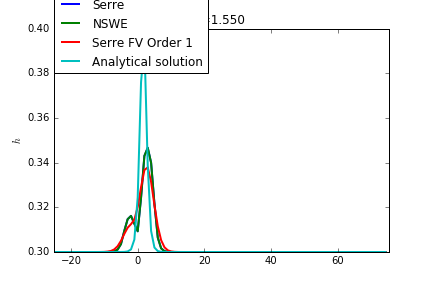
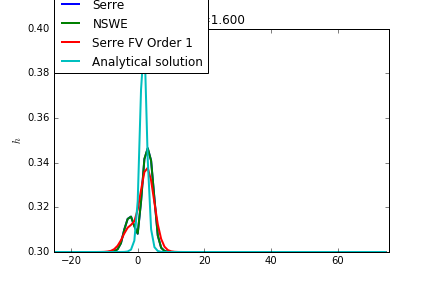
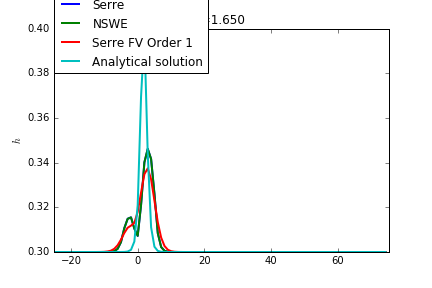
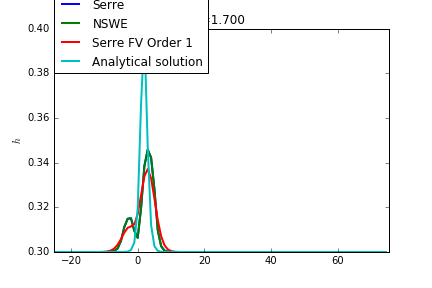
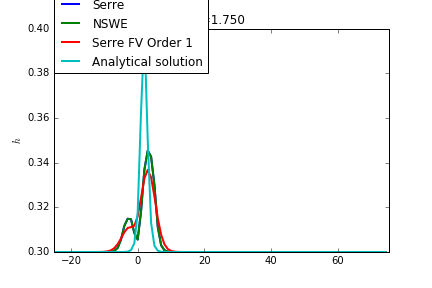
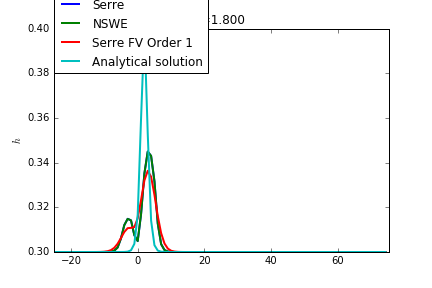
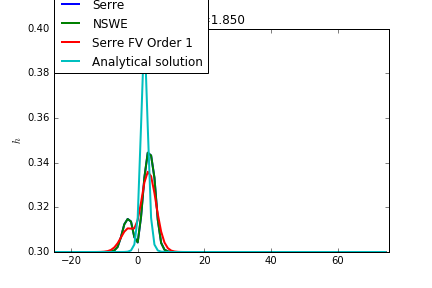
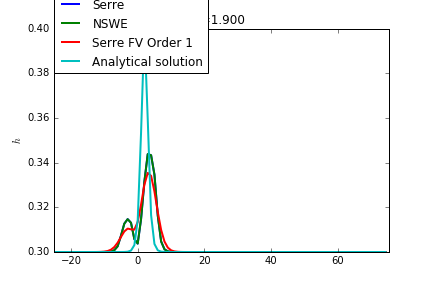
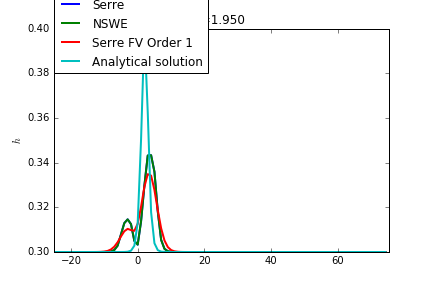
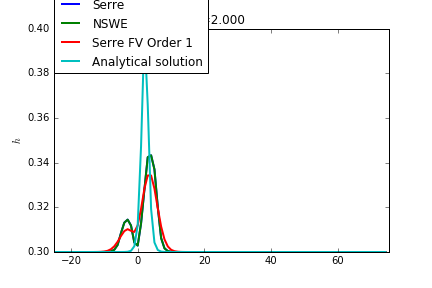

In [59]:
hallexact = np.copy(hall1)
uallexact = np.copy(uall1)

for i in range (tall1.size):
    hallexact[:,i],uallexact[:,i] = cnoidal.analyticalSolutionSolitary(x,tall1[i],a0,a1)

lb = ["Serre","NSWE","Serre FV Order 1", "Analytical solution"]
gF.plotAnimationNSolutions(4,x,np.array([hall1,hall2,hall3,hallexact]),tall1,xmin,xmax,hmin,hmax,lb,ylabel=r'$h$',location=(0.,0.8))

In [ ]:

lb = ["Serre","NSWE","Serre FV Order 1", "Analytical solution"]
gF.plotAnimationNSolutions(4,x,np.array([uall1,uall2,uall3,uallexact]),tall1,xmin,xmax,umin,umax,lb,ylabel=r'$u$',location=(0.,.7))

In [ ]:
print(np.linalg.norm(uall1-uallexact))
print(np.linalg.norm(hall1-hallexact))

In [ ]:
## G-N solitary wave solution (Marche paper)
#### First and second simulations : done with muscl2 (so two ghost cells) --> ok
#### Third simulation : done with order1 in advection (so one ghost cells) --> but
     #### I can't define a good periodic solution (i.e., inside the domain)

h0 = 0.5
a1 = 0.2*h0
k = 0.
g = 9.81
t = 0.0
H = 10.

L = 15.
xmin = -L
xmax = L
nx = 100

x,dx = serre.discretizeSpace(xmin,xmax,nx)
dt = .05

kappa = np.sqrt(3.*H)/(2.*h0*np.sqrt(h0+H))
h = h0 + a1*np.power(np.cosh(kappa*x),-2)
c = np.sqrt(g*(h+H))
u = c*(1.-h0/h)

u2 = np.copy(u)
h2 = np.copy(h)
u3 = np.copy(u)
h3 = np.copy(h)



BC1=np.array([0.,0.,0.,0.,0.,1.,0.,1.,0.,1.,0.,1.,0.])
BC2=np.array([0.,0.,nan,nan,0.,nan,nan,nan,0,0,0,0.,0.,0,nan,nan])
hall1,uall1,tall1 = serre.splitSerre(x,h,u,0,5.,serre.periodicDomainTwoGC,
                                     serre.periodicDomain2,BC1,BC2,dx,nx,vardt = False, dt = dt, splitSteps=3,
                                     order=2, fvsolver=muscl2.fluxes2, fdsolver=serre.EFDSolver)
hall2,uall2,tall2 = serre.NSWE(x,h2,u2,0,5.,serre.periodicDomainTwoGC,BC1,dx,nx,vardt = False, dt = dt)
hall3,uall3,tall3 = serre.splitSerre(x,h3,u3,0,5.,serre.periodicDomain,
                                     serre.periodicDomain2,BC1,BC2,dx,nx,vardt = False, dt = dt, splitSteps=3,
                                     order=2, fvsolver=nswe.fluxes, fdsolver=serre.EFDSolver, ghostcells=1)

umin = np.amin(np.concatenate((uall1,uall2,uall3)))
umax = np.amax(np.concatenate((uall1,uall2,uall3)))
hmin = np.amin(np.concatenate((hall1,hall2,hall3)))
hmax = np.amax(np.concatenate((hall1,hall2,hall3)))

print(np.linalg.norm(uall1-uall2))
print(np.linalg.norm(hall1-hall2))

In [ ]:
hallexact = np.copy(hall1)
uallexact = np.copy(uall1)

for i in range (tall1.size):
    hallexact[:,i] = h0 + a1*np.power(np.cosh(kappa*x-c*tall1[i]),-2)
    c = np.sqrt(g*(hallexact[:,i]+H))
    uallexact[:,i] = c*(1.-h0/hallexact[:,i])
    
print(np.linalg.norm(uall1-uallexact))
print(np.linalg.norm(hall1-hallexact))

In [ ]:
lb = ["Serre","NSWE","Serre FV O1", "Analytical solution"]
gF.plotAnimationNSolutions(4,x,np.array([uall1,uall2,uall3,uallexact]),tall1,xmin,xmax,umin,umax,lb,ylabel=r'$u$',
                          location=(0.,.7))

In [ ]:
gF.plotAnimationNSolutions(4,x,np.array([hall1,hall2,hall3,hallexact]),tall1,xmin,xmax,hmin,hmax,lb,ylabel=r'$h$',
                          location=(0.,.7))

# Validation : NSWE

In [ ]:
def newtonMethod(x0,f,fx) :
    
    x = x0
    eps = 1e-6
    while np.absolute(f(x)) > eps :
        x = x - f(x)/fx(x)
  
    return x

In [ ]:
def SWAnalyticalSolutionDry(x,t,x0,hl,g) :
    c = np.sqrt(g*hl)
    xa = x0 - t*c
    xb = x0 + 2.*t*c
    g = 9.81

    h[:] = np.where(x[:]<=xa, hl, np.where(x<xb,4./(9.*g)*np.power(c-(x[:]-x0)/(2.*t),2),0))
    u[:] = np.where(x[:]<=xa, 0,np.where(x<xb, 2./3.*(c+(x[:]-x0)/t),0))

    
    return h,u

t = 0.385

h,u =  SWAnalyticalSolution(x,t,x0,hl,g)

plt.plot(x,h)

In [ ]:
def SWAnalyticalSolutionWet(x,t,x0,hl,hr,g) :
    c = np.sqrt(g*hl)
    cm = newtonMethod(x0,cmEquation,cmEquationdx)
    xa = x0 - t*c
    xb = x0 + t*(2.*c - 3.*cm)
    xc = x0 + t*(2*cm*cm*(c-cm)/(cm*cm-g*hr))

    h[:] = np.where(x[:]<=xa, hl, np.where(x<xb,4./(9.*g)*np.power(c-(x[:]-x0)/(2.*t),2),np.where(x<xc,cm*cm/g,hr)))
    u[:] = np.where(x[:]<=xa, 0,np.where(x<xb, 2./3.*(c+(x[:]-x0)/t),np.where(x<xc, 2*(c-cm), 0)))
    
    return h,u

t = 0.8

hr = 5.
h,u =  SWAnalyticalSolutionWet(x,t,x0,hl,hr,g)

plt.plot(x,h)

In [ ]:
def cmEquation(x) :
    return -8.*g*hr*x*x*np.power(np.sqrt(g*hl)-x,2) + np.power(x*x-g*hr,2)*(x*x+g*hr)
    
def cmEquationdx(x) :
    return 6.*x*x*x*x*x - 36.*g*hr*x*x*x + 48.*g*hr*np.sqrt(g*hl)*x*x + (-2.*g*g*hr*hr -16.*g*g*hr*hl)*x


hl = 10.
hr = 5.
x0 = (hr+hl)/2.
print(cmEquation(x0))
x = newtonMethod(x0,cmEquation,cmEquationdx)

    

In [ ]:
### DRY

L = 50.
npoints = 40
dx = L/npoints
x = np.arange(0,L,dx)
dx = np.min(np.diff(x))
nx = x.shape[0]
cfl = 0.3
t0  = 0.
nt = 300
xmin = 0
xmax = L
x0 = L/2.
g = 9.81
hl = 10.
hr = 0.

h = np.zeros(x.shape[0])
u = np.zeros(x.shape[0])
h[:] = np.where(x<x0, hl, hr)
u[:] = 0.

BC1=np.array([0.,0.,0.,0.,0.,1.,1.,0.,0.,1.,1.,0.])
BC2=np.array([0.,0.,nan,nan,0.,nan,nan,nan,0,0,0,0.,0.,0,nan,nan])

hall1,uall1,tall1 = serre.NSWE(x,h,u,0,.5,serre.closedDomainTwoGC,BC1,dx,nx,vardt = False, dt = 0.005,
                               fvsolver=muscl2.fluxes2, ghostcells = 2)
#hall2,uall2,tall2 = serre.splitSerre(x,h,u,0,1.,serre.closedDomainTwoGC,
#                                     serre.genericOpenDomain2,None,BC2,dx,nx,vardt = False, dt = 0.05, splitSteps=3,
#                                     order=2, fvsolver = muscl2.fluxes2, fdsolver = serre.EFDSolverFM,
#                                    periodic = False, ghostcells=2)

hexact = np.copy(hall1)
uexact = np.copy(hall1)

for i in range(1,tall1.size):
    t = tall1[i]
    hexact[:,i],uexact[:,i] = SWAnalyticalSolutionDry(x,t,x0,hl,g)
    

hmin = np.amin(np.concatenate((hall1[2:-2])))
hmax = np.amax(np.concatenate((hall1[2:-2])))

lb = np.array(["Numerical","Exact"])
gF.plotAnimationNSolutions(2,x,np.array([hall1,hexact]),tall1,xmin,xmax,hmin,hmax,lb,ylabel=r'$h$',location=(.7,.7))

In [ ]:
### WET

L = 50.
npoints = 40
dx = L/npoints
x = np.arange(0,L,dx)
dx = np.min(np.diff(x))
nx = x.shape[0]
cfl = 0.3
t0  = 0.
nt = 300
xmin = 0
xmax = L
x0 = L/2.
g = 9.81
hl = 10.
hr = 5.

h = np.zeros(x.shape[0])
u = np.zeros(x.shape[0])
h[:] = np.where(x<x0, hl, hr)
u[:] = 0.

BC1=np.array([0.,0.,0.,0.,0.,1.,1.,0.,0.,1.,1.,0.])
BC2=np.array([0.,0.,nan,nan,0.,nan,nan,nan,0,0,0,0.,0.,0,nan,nan])

hall1,uall1,tall1 = serre.NSWE(x,h,u,0,5.,serre.closedDomainTwoGC,BC1,dx,nx,vardt = False, dt = 0.005,
                               fvsolver=nswe.fluxes, ghostcells = 1)
#hall2,uall2,tall2 = serre.splitSerre(x,h,u,0,1.,serre.closedDomainTwoGC,
#                                     serre.genericOpenDomain2,None,BC2,dx,nx,vardt = False, dt = 0.05, splitSteps=3,
#                                     order=2, fvsolver = muscl2.fluxes2, fdsolver = serre.EFDSolverFM,
#                                    periodic = False, ghostcells=2)

hexact = np.copy(hall1)
uexact = np.copy(hall1)

for i in range(1,tall1.size):
    t = tall1[i]
    hexact[:,i],uexact[:,i] = SWAnalyticalSolutionWet(x,t,x0,hl,hr,g)
    

hmin = np.amin(np.concatenate((hall1[2:-2])))
hmax = np.amax(np.concatenate((hall1[2:-2])))

lb = np.array(["Numerical","Exact"])
gF.plotAnimationNSolutions(2,x,np.array([hall1,hexact]),tall1,xmin,xmax,hmin,hmax,lb,ylabel=r'$h$',location=(.7,.7))

In [ ]:
gF.plotAnimationNSolutions(2,x,np.array([uall1,uexact]),tall1,xmin,xmax,umin,umax+.1,lb,ylabel=r'$u$',location=(.7,.7))